# Advanced Lane finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Compute the camera calibration matrix and distortion coefficients from chessboard images 

In the next cells the following is done:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import Line
import os
import MyTools

%matplotlib qt
%matplotlib inline

In [2]:
def GetImageAndObjectPoints(imgPaths, doPlots=False): 
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in imgPaths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if doPlots == True:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                cv2.imshow('img',img)
                cv2.waitKey(500)

    if doPlots == True:
        cv2.destroyAllWindows()
    
    return imgpoints, objpoints

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, x_, y_ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist


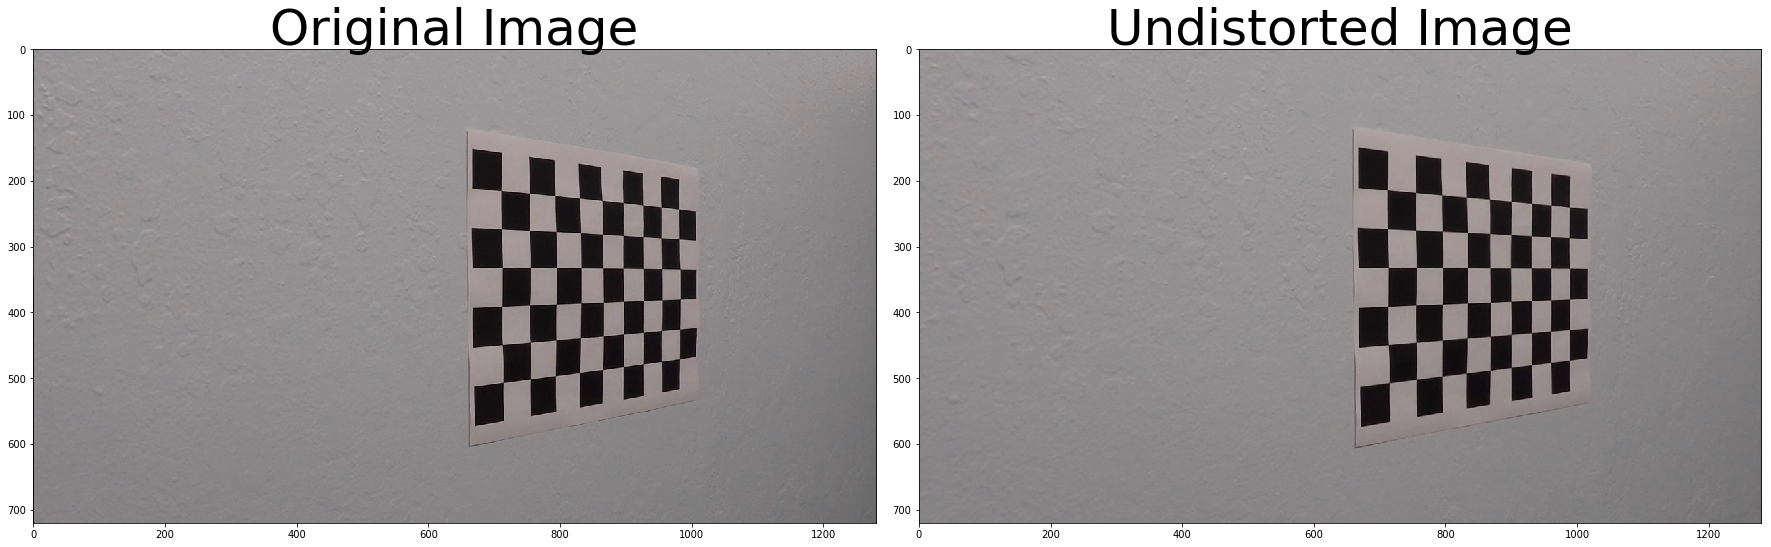

In [4]:
# ImgSavePath
imgSavePath = './output_images/'
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')    

imgpoints, objpoints = GetImageAndObjectPoints(images, doPlots=False) 

# Use the objpoints and imgpoints found to Calibrate the camera and show result in an example image
img = cv2.imread(images[4])
img_undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Use color and gradient transforms to obtain a binary image
In the following, I use the following techniques to obtain a good binary image of the road:
* Color transform to HSV, using the S channel (best result)
* Then I run a canny transform to get a good binary image
* Merge the transformed images to a best candidate

In [5]:
# Load Test images and undistort
testImages = glob.glob('./test_images/test*.jpg')
testImage = './output_images/frame018.jpeg' #testImages[0]
print('Image being used: ' + testImage)
img = cv2.imread(testImage)
img_undist = cv2.undistort(img, mtx, dist, None, mtx)

Image being used: ./output_images/frame018.jpeg


In [6]:
def CannyDetect(img):
    # Use blurring and canny transform to obtain a trhesholding image
    low_threshold  = 80
    high_threshold = 130
    # Gausian filter image for removing noise edges
    img_canny = cv2.GaussianBlur(img, (3, 3), 0)
    # Canny edge detection
    img_canny = cv2.Canny(img_canny, low_threshold, high_threshold)
    
    return img_canny

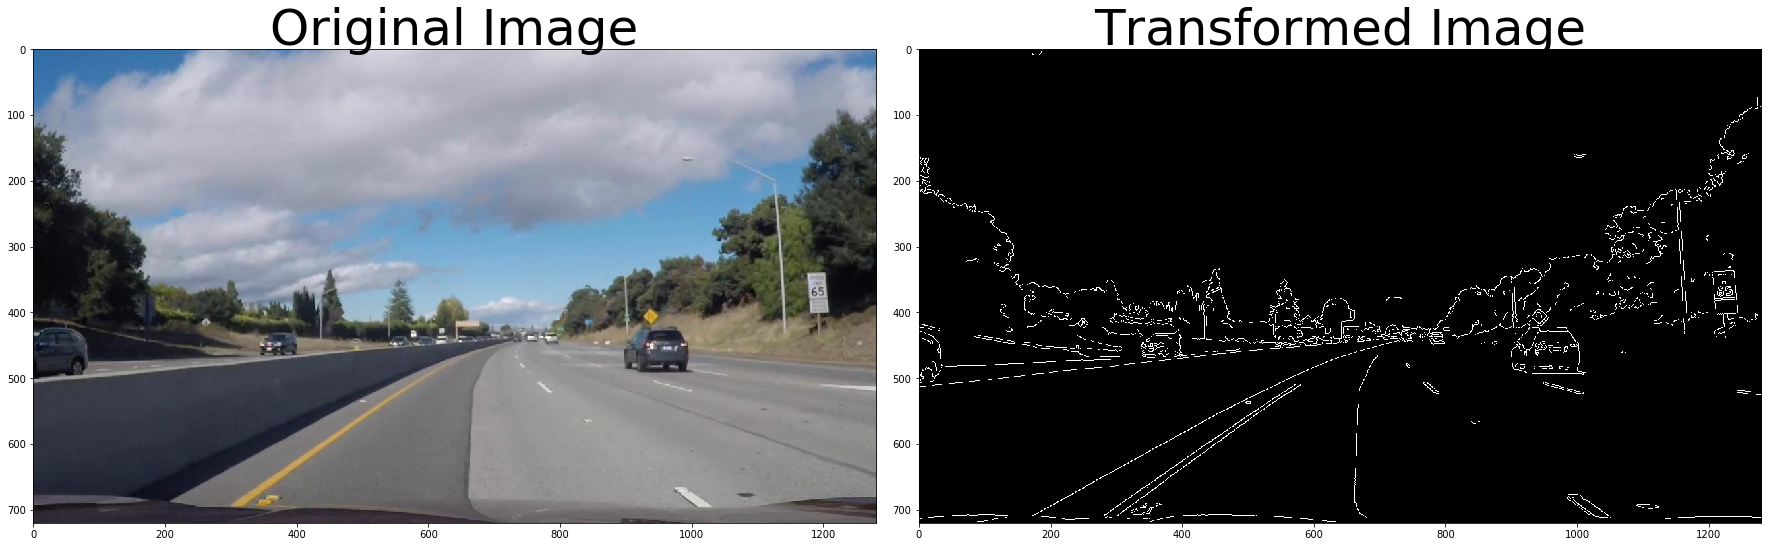

In [7]:
img_canny = CannyDetect(img_undist)
# Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_canny,'gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def ColorThreshold(img):
    # Use Color transform to obtain a threshold image
    l_Thres = 200
    s_Thres = 100
    Hue_Thres = 15 # Yellow lines
    Hue_Width = 5
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = img_hls[:,:,0]
    l = img_hls[:,:,1]
    s = img_hls[:,:,2]
    h_channel = np.zeros_like(h)
    l_channel = np.zeros_like(h)
    s_channel = np.zeros_like(h)
    h_channel[(h > Hue_Thres) & (h < Hue_Thres+Hue_Width)] = 255
    l_channel[l > l_Thres] = 255
    s_channel[s > s_Thres] = 255
    
    combined = h_channel + l_channel + s_channel
    
    return combined, h_channel, l_channel, s_channel

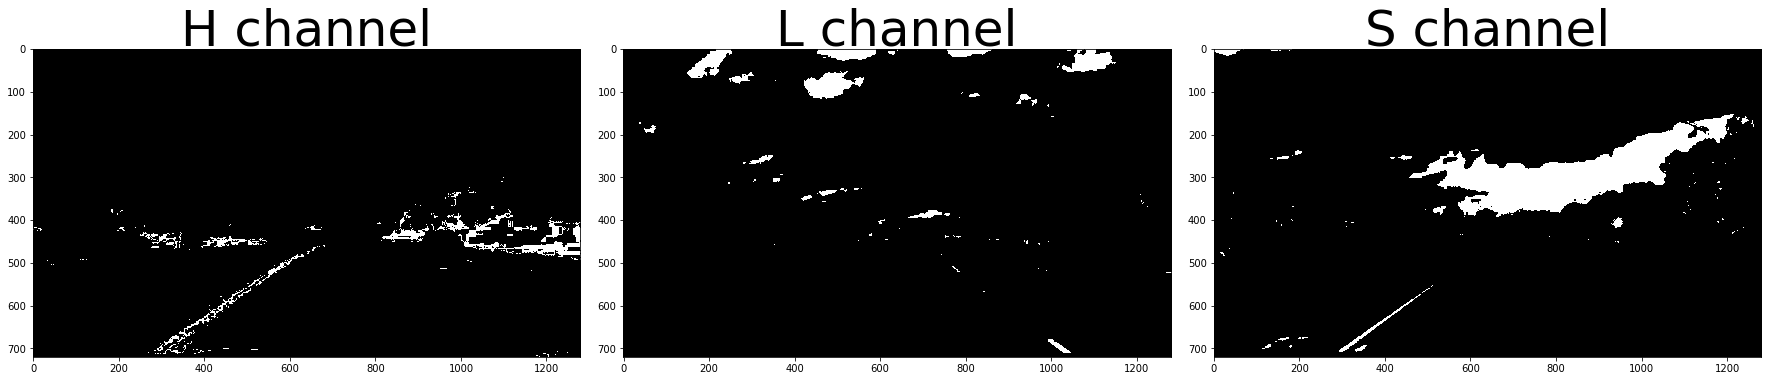

In [9]:
img_hls, h_channel, l_channel, s_channel = ColorThreshold(img_undist)

# Plot results
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(h_channel,'gray')
ax1.set_title('H channel', fontsize=50)
ax2.imshow(l_channel,'gray')
ax2.set_title('L channel', fontsize=50)
ax3.imshow(s_channel,'gray')
ax3.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
def CombineBinaryImages(img1, img2):
    # Combine images
    img_binary = np.zeros_like(img1)
    img_binary[img1.nonzero()] = 255
    img_binary[img2.nonzero()] = 255
    return img_binary
    

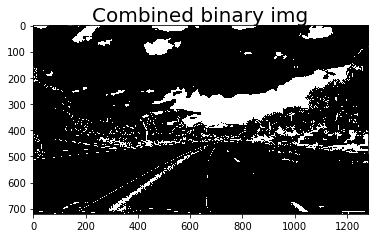

In [11]:
img_binary = CombineBinaryImages(img_hls, img_canny)

plt.imshow(img_binary,'gray')
plt.title('Combined binary img', fontsize=20)

## Apply a perspective transform to rectify binary image ("birds-eye view")

* Using a straight road image, find the perspective transform lines (or rectangle points) that can be used to transform images with
* Apply perspective transform using the points find, and draw a rectangle on the image road, and transform the road image back



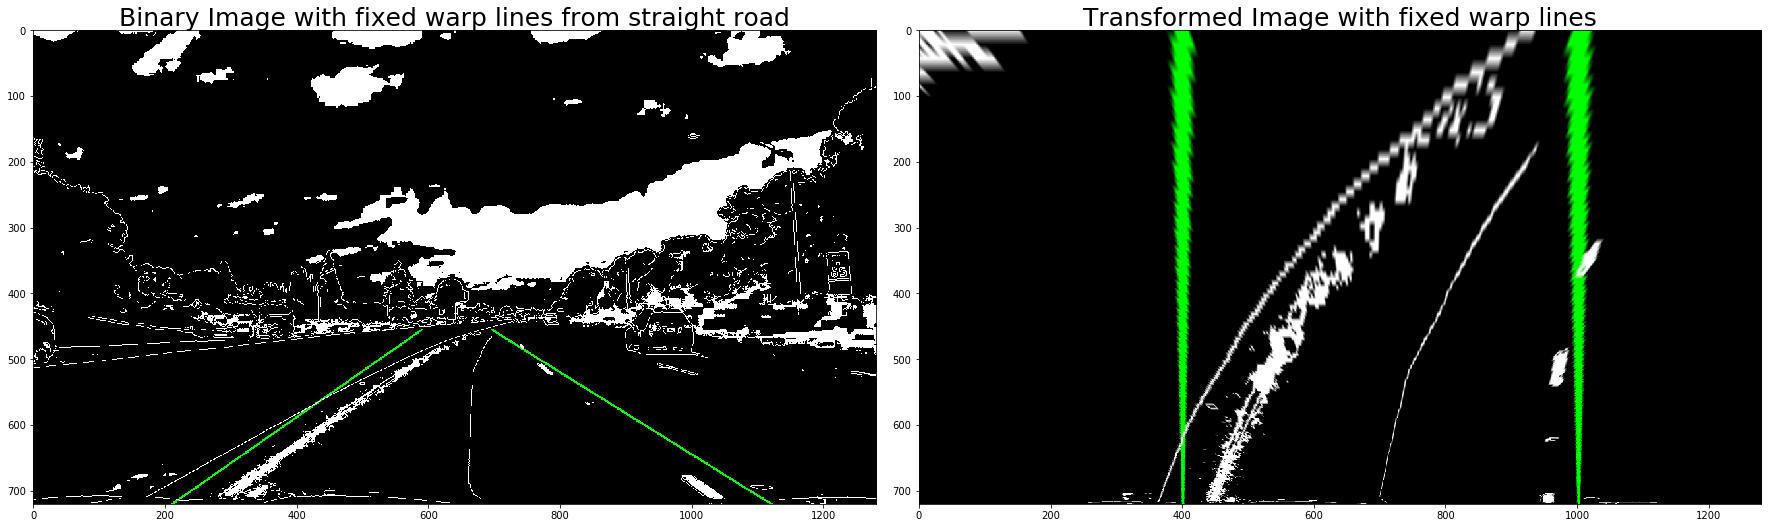

In [12]:
# Define some source points for perspective transform
dimY, dimX = img_binary.shape
src = np.float32([(210, dimY),(590, 455),(695, 455),(1120, dimY)])
# destination points
dst = np.float32([(400, dimY),(400, 0),(1000, 0),(1000, dimY)])

# Create an image to draw the lines on
warp_lines = np.zeros_like(img_binary).astype(np.uint8)
warp_lines = np.dstack((warp_lines, warp_lines, warp_lines))
# Draw the lane onto the warped blank image
cv2.line(warp_lines, (src[0,0],src[0,1]), (src[1,0],src[1,1]),(0,255, 0),2)
cv2.line(warp_lines, (src[2,0],src[2,1]), (src[3,0],src[3,1]),(0,255, 0),2)

# Add Warp lines and binary image together as color image
img_binary_col = np.dstack((img_binary,img_binary,img_binary)) + warp_lines

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
img_warped_bin_col = cv2.warpPerspective(img_binary_col, M, (dimX, dimY))
img_warped_bin = cv2.warpPerspective(img_binary, M, (dimX, dimY))

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_BinImgWLines.jpg', imgSavePath, img_binary_col)
MyTools.MyImageWrite(name + '_BinImgBirdsEye.jpg', imgSavePath, img_warped_bin_col)

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_binary_col)
ax1.set_title('Binary Image with fixed warp lines from straight road', fontsize=25)
ax2.imshow(img_warped_bin_col)
ax2.set_title('Transformed Image with fixed warp lines', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

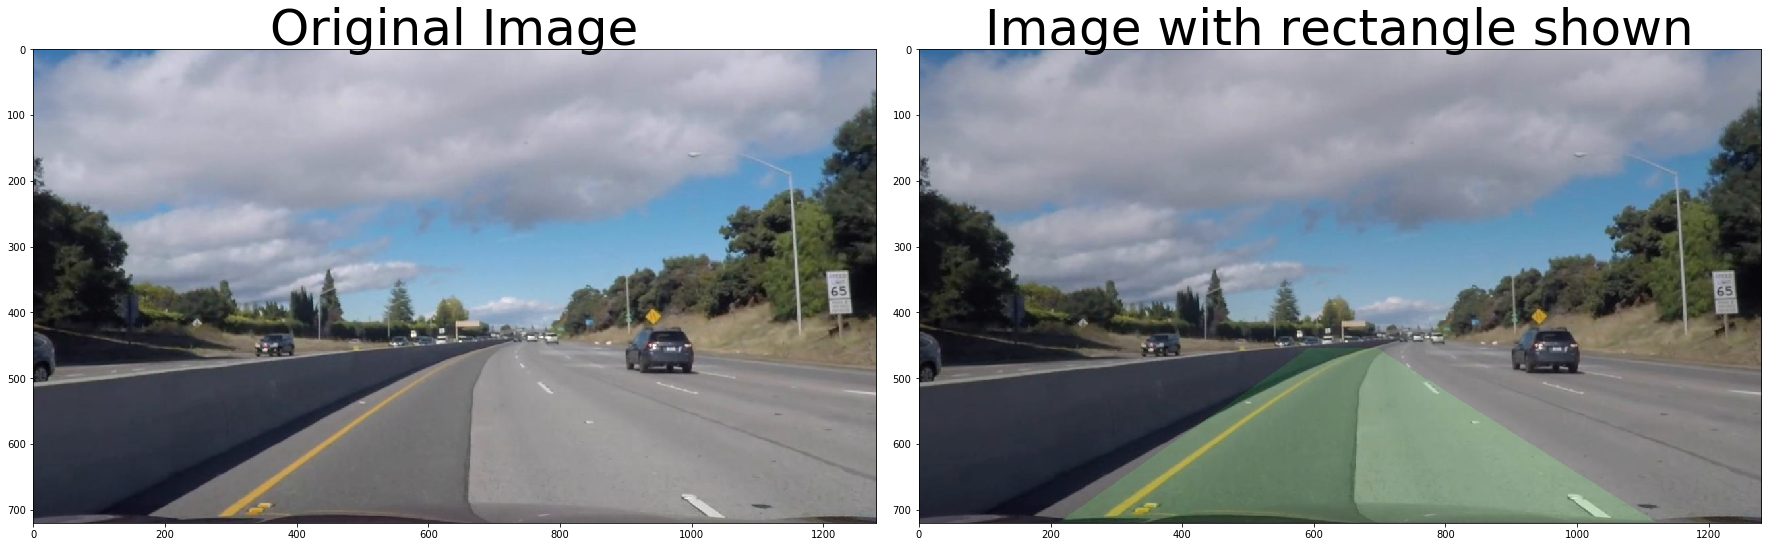

In [13]:
# Transform original image to birds eye, and apply a green rectangle and inverse transform image back to 
# drivers view

# Create rectangle image in birds eye view
img_rect = np.zeros_like(img_undist)
cv2.rectangle(img_rect, (dst[0,0],dst[0,1]), (dst[2,0],dst[2,1]), (0,255, 0),-1)
# Warp the rectangle using OpenCV warpPerspective() with inverse(M) 
img_rect_trans = cv2.warpPerspective(img_rect, np.linalg.inv(M), (dimX, dimY))

img_with_rect = cv2.addWeighted(img_undist, 0.9, img_rect_trans, 0.1, 0.0)

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_ImageWRectangle.jpg', imgSavePath, img_with_rect)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(img_with_rect, cv2.COLOR_BGR2RGB))
ax2.set_title('Image with rectangle shown', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Calculate line curvature from lane pixels
Using the Line() class with the binary and birds eye transformed image the following is done:
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.

Pixels found in left window: 0 pixels: 2377 
Pixels found in left window: 1 pixels: 3451 
Pixels found in left window: 2 pixels: 4397 
Pixels found in left window: 3 pixels: 4829 
Pixels found in left window: 4 pixels: 4989 
Pixels found in left window: 5 pixels: 3525 
Pixels found in left window: 6 pixels: 3873 
Pixels found in left window: 7 pixels: 3387 
Pixels found in left window: 8 pixels: 2367 
Pixels found in right window: 2 pixels: 1289 
Pixels found in right window: 4 pixels: 1161 
Left and right line search x-val start 468.0 and 962


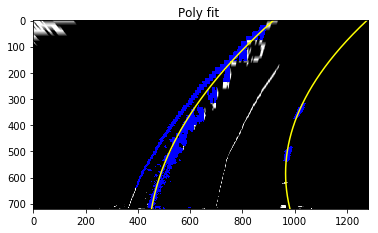

In [14]:
# get left and right lane Line objects:
LeftLane = Line.Line('left')
RightLane = Line.Line('right')

# Find lane pixels
LeftLane.find_lane_pixels(img_warped_bin)
RightLane.find_lane_pixels(img_warped_bin)
print('Left and right line search x-val start {} and {}'.format(LeftLane.bestx, RightLane.bestx))

img_plot = LeftLane.PlotPolynomialFit(img_warped_bin)
img_plot = RightLane.PlotPolynomialFit(img_plot)

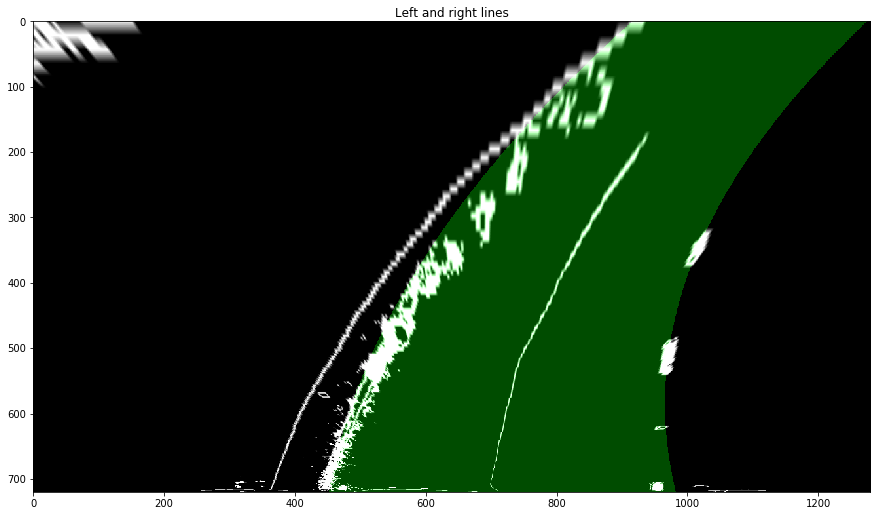

In [15]:
# Get image with green poly curve
img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped_bin, LeftLane.best_fit, RightLane.best_fit)

# Plot image ontop of binary warped image
MyTools.MergeAndPlotBGRImages(cv2.cvtColor(img_warped_bin, cv2.COLOR_GRAY2BGR), img_polyfit, 'Left and right lines')







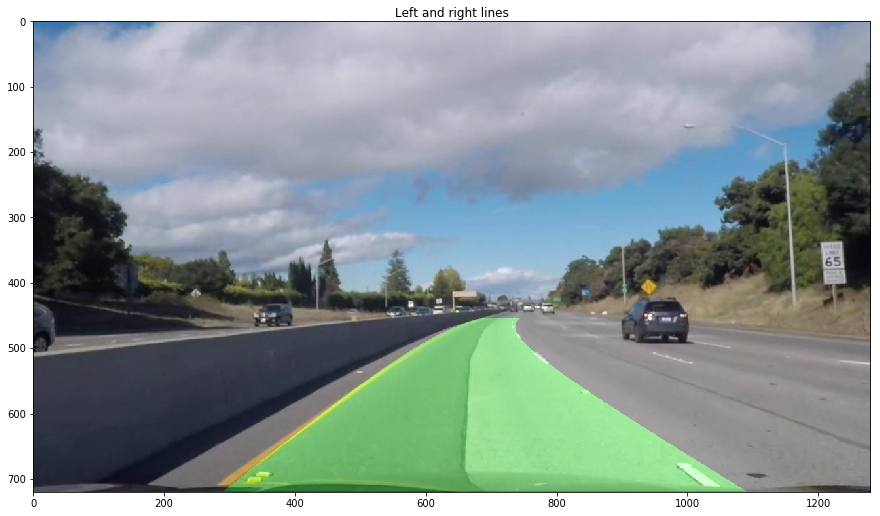

In [16]:
# Warp green poly curve image to drivers view
img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))

# plot warped poly curve image ontop of road image
MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')

In [21]:

    
def LanePipeline(img):
    dimY, dimX = img.shape[:2]
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)    
    img_canny  = CannyDetect(img_undist)
    img_col, h_channel, l_channel, s_channel = ColorThreshold(img_undist)
    img_binary = CombineBinaryImages(img_canny, img_col)
    img_warped = cv2.warpPerspective(img_binary, M, (dimX, dimY))
    
    # Get an estimate on the left and right base x values
    LeftLane.find_lane_pixels(img_warped)
    RightLane.find_lane_pixels(img_warped)  
    
    img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped, LeftLane.best_fit, RightLane.best_fit)

    img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))

    LaneOffset = 'Offset: {:.2f}m'.format(MyTools.CalculateLaneOffset(LeftLane,RightLane))
    LaneCurve = 'Radius: {:.0f}m'.format(LeftLane.radius_of_curvature)
    cv2.putText(img_undist, LaneOffset, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    cv2.putText(img_undist, LaneCurve, (50,125), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0),3)
    
    img_out = cv2.addWeighted(img_undist, 1, img_polyfit_warped, 0.3, 0)   
    #MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')
    #img_out = LeftLane.PlotPolynomialFit(img_warped,plot=0)
    #img_out = RightLane.PlotPolynomialFit(img_out,plot=0)
    return img_out
    

In [18]:
# get left and right lane Line objects:
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
testImage = './output_images/frame006.jpeg'
img = cv2.imread(testImage)

for n in range(2):
    img_out = LanePipeline(img);
    #cv2.imshow('img',img_out)
    RightLane.PlotPolynomialFit(img_out,plot=1)
    cv2.waitKey(2000)
    #cv2.destroyAllWindows()

Pixels found in left window: 1 pixels: 1982 
Pixels found in left window: 2 pixels: 4265 
Pixels found in left window: 3 pixels: 4071 
Pixels found in left window: 4 pixels: 3087 
Pixels found in left window: 5 pixels: 3121 
Pixels found in left window: 6 pixels: 3456 
Pixels found in left window: 7 pixels: 1597 
lineCurvature: 469, x-poly: 461.02681056077444, x_diff: 109.0, badPos: False
Pixels found in right window: 0 pixels: 1207 
Pixels found in right window: 1 pixels: 1544 
Pixels found in right window: 6 pixels: 1316 
Pixels found in right window: 7 pixels: 6838 


TypeError: non-empty format string passed to object.__format__

21579
10905


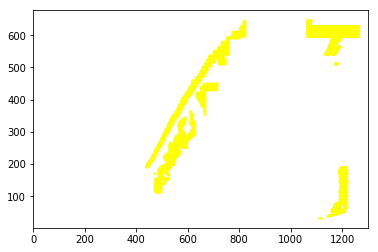

In [19]:
print(len(LeftLane.allx))
print(len(RightLane.allx))
plt.scatter(RightLane.allx, 750 - RightLane.ally,color='yellow',s=1)
plt.xlim([0,1300])
plt.hold
plt.scatter(LeftLane.allx, 750 - LeftLane.ally,color='yellow',s=0.1)

In [21]:
# Convert movie to pictures

from moviepy.editor import VideoFileClip
import os
vidClip = VideoFileClip('./challenge_video.mp4')

vidFiles = os.path.join(imgSavePath,'frame%03d.jpeg')
vidClip.write_images_sequence(vidFiles, fps=2)


t:   9%|▉         | 3/33 [00:00<00:01, 29.25it/s, now=None]

Moviepy - Writing frames ./output_images/frame%03d.jpeg.


Moviepy - Done writing frames ./output_images/frame%03d.jpeg.


['./output_images/frame000.jpeg',
 './output_images/frame001.jpeg',
 './output_images/frame002.jpeg',
 './output_images/frame003.jpeg',
 './output_images/frame004.jpeg',
 './output_images/frame005.jpeg',
 './output_images/frame006.jpeg',
 './output_images/frame007.jpeg',
 './output_images/frame008.jpeg',
 './output_images/frame009.jpeg',
 './output_images/frame010.jpeg',
 './output_images/frame011.jpeg',
 './output_images/frame012.jpeg',
 './output_images/frame013.jpeg',
 './output_images/frame014.jpeg',
 './output_images/frame015.jpeg',
 './output_images/frame016.jpeg',
 './output_images/frame017.jpeg',
 './output_images/frame018.jpeg',
 './output_images/frame019.jpeg',
 './output_images/frame020.jpeg',
 './output_images/frame021.jpeg',
 './output_images/frame022.jpeg',
 './output_images/frame023.jpeg',
 './output_images/frame024.jpeg',
 './output_images/frame025.jpeg',
 './output_images/frame026.jpeg',
 './output_images/frame027.jpeg',
 './output_images/frame028.jpeg',
 './output_ima

In [22]:
LeftLane = Line.Line('left')
RightLane = Line.Line('right')
MyTools.ProcessVideo('./challenge_video.mp4', './output_images/', LanePipeline)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Pixels found in left window: 0 pixels: 1918 
Pixels found in left window: 1 pixels: 2465 
Pixels found in left window: 2 pixels: 2548 
Pixels found in left window: 3 pixels: 2370 
Pixels found in left window: 4 pixels: 2695 
Pixels found in left window: 5 pixels: 1597 
Pixels found in left window: 7 pixels: 4624 
Pixels found in left window: 8 pixels: 1594 
Pixels found in right window: 0 pixels: 1564 
Pixels found in right window: 1 pixels: 1496 
Pixels found in right window: 2 pixels: 1591 
Pixels found in right window: 3 pixels: 1497 
Pixels found in right window: 4 pixels: 2691 
Pixels found in right window: 5 pixels: 2383 
Moviepy - Building video ./output_images/challenge_video.mp4.
Moviepy - Writing video ./output_images/challenge_video.mp4

Pixels found in left poly pixels: 17102 
Pixels found in right poly pixels: 11510 


t:   1%|          | 4/485 [00:00<00:35, 13.44it/s, now=None]

Pixels found in left poly pixels: 16928 
Pixels found in right poly pixels: 12451 
Pixels found in left poly pixels: 16585 
Pixels found in right poly pixels: 12360 
Pixels found in left poly pixels: 17240 
Pixels found in right poly pixels: 12391 


t:   2%|▏         | 8/485 [00:00<00:37, 12.62it/s, now=None]

Pixels found in left poly pixels: 16547 
Pixels found in right poly pixels: 11889 
Pixels found in left poly pixels: 16743 
Pixels found in right poly pixels: 11320 
Pixels found in left poly pixels: 15892 
Pixels found in right poly pixels: 11087 


t:   2%|▏         | 10/485 [00:00<00:39, 12.11it/s, now=None]

Pixels found in left poly pixels: 15828 
Pixels found in right poly pixels: 10861 
Pixels found in left poly pixels: 15041 
Pixels found in right poly pixels: 10843 
Pixels found in left poly pixels: 13312 
Pixels found in right poly pixels: 10972 


t:   3%|▎         | 14/485 [00:01<00:39, 12.05it/s, now=None]

Pixels found in left poly pixels: 13339 
Pixels found in right poly pixels: 11286 
Pixels found in left poly pixels: 14679 
Pixels found in right poly pixels: 11949 
Pixels found in left poly pixels: 13032 
Pixels found in right poly pixels: 12393 


t:   3%|▎         | 16/485 [00:01<00:40, 11.67it/s, now=None]

Pixels found in left poly pixels: 15341 
Pixels found in right poly pixels: 12585 
Pixels found in left poly pixels: 16034 
Pixels found in right poly pixels: 12959 


t:   4%|▎         | 18/485 [00:01<00:42, 10.91it/s, now=None]

Pixels found in left poly pixels: 15633 
Pixels found in right poly pixels: 13218 
Pixels found in left poly pixels: 16017 
Pixels found in right poly pixels: 12840 
Pixels found in left poly pixels: 15051 


t:   4%|▍         | 20/485 [00:01<00:42, 10.82it/s, now=None]

Pixels found in right poly pixels: 13525 
Pixels found in left poly pixels: 15717 
Pixels found in right poly pixels: 13232 
Pixels found in left poly pixels: 15144 
Pixels found in right poly pixels: 11860 


t:   5%|▍         | 24/485 [00:02<00:41, 11.22it/s, now=None]

Pixels found in left poly pixels: 14452 
Pixels found in right poly pixels: 12995 
Pixels found in left poly pixels: 14084 
Pixels found in right poly pixels: 12305 
Pixels found in left poly pixels: 12846 
Pixels found in right poly pixels: 12928 


t:   5%|▌         | 26/485 [00:02<00:41, 11.17it/s, now=None]

Pixels found in left poly pixels: 13624 
Pixels found in right poly pixels: 13089 
Pixels found in left poly pixels: 13827 
Pixels found in right poly pixels: 12979 
Pixels found in left poly pixels: 12986 
Pixels found in right poly pixels: 12673 


t:   6%|▌         | 30/485 [00:02<00:41, 11.06it/s, now=None]

Pixels found in left poly pixels: 13009 
Pixels found in right poly pixels: 12925 
Pixels found in left poly pixels: 12967 
Pixels found in right poly pixels: 12402 
Pixels found in left poly pixels: 12692 
Pixels found in right poly pixels: 12431 


t:   7%|▋         | 32/485 [00:02<00:41, 10.97it/s, now=None]

Pixels found in left poly pixels: 12791 
Pixels found in right poly pixels: 12303 
Pixels found in left poly pixels: 14480 
Pixels found in right poly pixels: 12735 
Pixels found in left poly pixels: 13881 
Pixels found in right poly pixels: 12777 


t:   7%|▋         | 34/485 [00:03<00:42, 10.61it/s, now=None]

Pixels found in left poly pixels: 14127 
Pixels found in right poly pixels: 12704 
Pixels found in left poly pixels: 14049 
Pixels found in right poly pixels: 12404 


t:   8%|▊         | 38/485 [00:03<00:42, 10.55it/s, now=None]

Pixels found in left poly pixels: 14289 
Pixels found in right poly pixels: 12135 
Pixels found in left poly pixels: 14127 
Pixels found in right poly pixels: 11660 
Pixels found in left poly pixels: 13766 
Pixels found in right poly pixels: 11381 


t:   8%|▊         | 40/485 [00:03<00:41, 10.82it/s, now=None]

Pixels found in left poly pixels: 13642 
Pixels found in right poly pixels: 10798 
Pixels found in left poly pixels: 14700 
Pixels found in right poly pixels: 11219 
Pixels found in left poly pixels: 16194 
Pixels found in right poly pixels: 11564 


t:   9%|▊         | 42/485 [00:03<00:39, 11.12it/s, now=None]

Pixels found in left poly pixels: 15484 
Pixels found in right poly pixels: 12113 
Pixels found in left poly pixels: 16515 
Pixels found in right poly pixels: 11618 
Pixels found in left poly pixels: 17533 
Pixels found in right poly pixels: 11176 


t:   9%|▉         | 46/485 [00:04<00:39, 11.12it/s, now=None]

Pixels found in left poly pixels: 17458 
Pixels found in left poly pixels: 16471 
Pixels found in right poly pixels: 10384 
Pixels found in left poly pixels: 17916 
Pixels found in right poly pixels: 11103 


t:  10%|▉         | 48/485 [00:04<00:38, 11.37it/s, now=None]

Pixels found in left poly pixels: 17525 
Pixels found in right poly pixels: 10884 
Pixels found in left poly pixels: 18036 
Pixels found in right poly pixels: 11028 
Pixels found in left poly pixels: 18146 
Pixels found in right poly pixels: 10454 


t:  11%|█         | 52/485 [00:04<00:40, 10.56it/s, now=None]

Pixels found in left poly pixels: 18064 
Pixels found in right poly pixels: 10359 
lineCurvature: 518, x-poly: 1073.0870718178303, x_diff: 74.1, badPos: False
Pixels found in left poly pixels: 17577 
Pixels found in right poly pixels: 10694 
lineCurvature: 407, x-poly: 1080.8765488409601, x_diff: 81.9, badPos: False


t:  11%|█         | 54/485 [00:04<00:41, 10.44it/s, now=None]

Pixels found in left poly pixels: 17156 
Pixels found in left poly pixels: 16738 
Pixels found in left poly pixels: 17341 
Pixels found in right poly pixels: 10556 
lineCurvature: 454, x-poly: 1087.6736831256173, x_diff: 88.7, badPos: False


t:  12%|█▏        | 56/485 [00:05<00:40, 10.48it/s, now=None]

Pixels found in left poly pixels: 17253 
Pixels found in left poly pixels: 17564 
Pixels found in left poly pixels: 17831 


t:  12%|█▏        | 60/485 [00:05<00:39, 10.66it/s, now=None]

Pixels found in left poly pixels: 17705 
Pixels found in left poly pixels: 17427 
Pixels found in left poly pixels: 17626 


t:  13%|█▎        | 62/485 [00:05<00:41, 10.13it/s, now=None]

Pixels found in left poly pixels: 19139 
Pixels found in right window: 0 pixels: 1634 
Pixels found in right window: 1 pixels: 1389 
Pixels found in right window: 2 pixels: 1892 
Pixels found in right window: 3 pixels: 2275 
Pixels found in right window: 4 pixels: 2010 
Pixels found in left poly pixels: 18529 
Pixels found in left poly pixels: 18602 


t:  14%|█▎        | 66/485 [00:06<00:41, 10.02it/s, now=None]

Pixels found in left poly pixels: 17995 
Pixels found in left poly pixels: 18824 


t:  14%|█▍        | 68/485 [00:06<00:40, 10.30it/s, now=None]

Pixels found in left poly pixels: 18879 
Pixels found in left poly pixels: 17643 


t:  14%|█▍        | 70/485 [00:06<00:42,  9.87it/s, now=None]

Pixels found in left poly pixels: 18580 
Pixels found in left poly pixels: 16982 
Pixels found in left poly pixels: 18706 


t:  15%|█▍        | 72/485 [00:06<00:39, 10.46it/s, now=None]

Pixels found in left poly pixels: 18816 
Pixels found in left poly pixels: 18784 
Pixels found in left poly pixels: 19794 
Pixels found in right window: 1 pixels: 1471 
Pixels found in right window: 2 pixels: 2039 
Pixels found in right window: 3 pixels: 2099 
Pixels found in right window: 8 pixels: 4324 


t:  16%|█▌        | 76/485 [00:07<00:40, 10.12it/s, now=None]

Pixels found in left poly pixels: 17005 
Pixels found in left poly pixels: 18595 


t:  16%|█▌        | 78/485 [00:07<00:39, 10.30it/s, now=None]

Pixels found in left poly pixels: 19378 
Pixels found in left poly pixels: 19314 
Pixels found in left poly pixels: 19713 
Pixels found in right poly pixels: 10467 


t:  17%|█▋        | 82/485 [00:07<00:37, 10.79it/s, now=None]

Pixels found in left poly pixels: 17953 
Pixels found in right poly pixels: 12454 
Pixels found in left poly pixels: 17459 
Pixels found in right poly pixels: 10795 
Pixels found in left poly pixels: 16153 
Pixels found in right poly pixels: 10683 


t:  17%|█▋        | 84/485 [00:07<00:36, 10.91it/s, now=None]

Pixels found in left poly pixels: 18536 
Pixels found in right poly pixels: 11155 
Pixels found in left poly pixels: 18334 
Pixels found in right poly pixels: 11091 
Pixels found in left poly pixels: 17477 


t:  18%|█▊        | 86/485 [00:07<00:37, 10.54it/s, now=None]

Pixels found in right poly pixels: 10792 
Pixels found in left poly pixels: 17180 
Pixels found in right poly pixels: 10203 
Pixels found in left poly pixels: 16590 
Pixels found in right poly pixels: 10131 


t:  18%|█▊        | 88/485 [00:08<00:37, 10.64it/s, now=None]

Pixels found in left poly pixels: 13641 
Pixels found in left poly pixels: 12243 
Pixels found in left poly pixels: 11773 


t:  19%|█▉        | 92/485 [00:08<00:37, 10.47it/s, now=None]

Pixels found in left poly pixels: 12559 
Pixels found in left poly pixels: 12966 
Pixels found in left poly pixels: 11972 


t:  19%|█▉        | 94/485 [00:08<00:36, 10.68it/s, now=None]

Pixels found in left poly pixels: 12102 
Pixels found in left poly pixels: 12390 


t:  20%|██        | 98/485 [00:09<00:36, 10.74it/s, now=None]

Pixels found in left poly pixels: 10898 


t:  21%|██        | 100/485 [00:09<00:36, 10.69it/s, now=None]

Pixels found in right window: 3 pixels: 1111 
Pixels found in right window: 5 pixels: 5406 
Pixels found in right window: 8 pixels: 4550 
Pixels found in right window: 5 pixels: 4454 
Pixels found in right window: 8 pixels: 7706 
lineCurvature: 148, x-poly: 545.145115459994, x_diff: 402.9, badPos: True


t:  21%|██        | 102/485 [00:09<00:35, 10.69it/s, now=None]

Pixels found in right window: 5 pixels: 4410 
Pixels found in right window: 8 pixels: 6561 
lineCurvature: 300, x-poly: 1245.4268785385816, x_diff: 297.4, badPos: False
Pixels found in right window: 0 pixels: 1249 
Pixels found in right window: 5 pixels: 4434 
Pixels found in right window: 0 pixels: 1229 
Pixels found in right window: 5 pixels: 4942 


t:  21%|██▏       | 104/485 [00:09<00:35, 10.74it/s, now=None]

Pixels found in right window: 5 pixels: 4475 
lineCurvature: 133, x-poly: 2830.2686906191016, x_diff: 1875.3, badPos: False
Pixels found in right window: 2 pixels: 1057 
Pixels found in right window: 5 pixels: 5251 
lineCurvature: 3, x-poly: 244.32220117180415, x_diff: 744.7, badPos: True
Pixels found in right window: 2 pixels: 1326 
Pixels found in right window: 5 pixels: 4909 
lineCurvature: 5, x-poly: 378.0038738845544, x_diff: 612.0, badPos: True


t:  22%|██▏       | 108/485 [00:10<00:36, 10.31it/s, now=None]

Pixels found in right window: 2 pixels: 1340 
Pixels found in right window: 5 pixels: 4614 
lineCurvature: 12, x-poly: 546.1344070756428, x_diff: 434.9, badPos: True
Pixels found in left window: 1 pixels: 2164 
Pixels found in left window: 2 pixels: 2378 
Pixels found in left window: 3 pixels: 1758 
Pixels found in left window: 4 pixels: 1791 
Pixels found in left window: 5 pixels: 1453 
Pixels found in right window: 2 pixels: 1122 
Pixels found in right window: 4 pixels: 1306 
Pixels found in right window: 5 pixels: 3838 
lineCurvature: 41, x-poly: 717.5094001248447, x_diff: 259.5, badPos: False
Pixels found in right window: 4 pixels: 3509 
Pixels found in right window: 5 pixels: 1050 
lineCurvature: 88, x-poly: -4722.913859061143, x_diff: 5695.9, badPos: True


t:  23%|██▎       | 110/485 [00:10<00:35, 10.52it/s, now=None]

Pixels found in left poly pixels: 10810 
Pixels found in right window: 1 pixels: 1002 
Pixels found in right window: 4 pixels: 4419 
Pixels found in right window: 8 pixels: 5689 
Pixels found in left poly pixels: 13277 
Pixels found in right window: 1 pixels: 1285 
Pixels found in right window: 4 pixels: 3709 
Pixels found in right window: 8 pixels: 9233 
Pixels found in left poly pixels: 13195 
Pixels found in right window: 1 pixels: 1283 
Pixels found in right window: 4 pixels: 3083 
Pixels found in right window: 8 pixels: 7889 


t:  24%|██▎       | 114/485 [00:10<00:36, 10.25it/s, now=None]

Pixels found in left poly pixels: 14017 
Pixels found in right window: 1 pixels: 1002 
Pixels found in right window: 3 pixels: 1244 
Pixels found in right window: 4 pixels: 2771 
Pixels found in right window: 8 pixels: 7758 
Pixels found in left poly pixels: 12139 
Pixels found in left poly pixels: 12972 


t:  24%|██▍       | 116/485 [00:10<00:35, 10.40it/s, now=None]

Pixels found in left poly pixels: 12660 
Pixels found in left poly pixels: 12186 
Pixels found in left poly pixels: 11099 


t:  25%|██▍       | 120/485 [00:11<00:37,  9.71it/s, now=None]

Pixels found in left poly pixels: 10633 


t:  26%|██▌       | 126/485 [00:11<00:36,  9.79it/s, now=None]

Pixels found in right window: 1 pixels: 1871 
Pixels found in right window: 5 pixels: 1485 
Pixels found in right window: 6 pixels: 3946 
lineCurvature: 82, x-poly: 839.5663131218282, x_diff: 121.4, badPos: False
Pixels found in right window: 1 pixels: 2146 
Pixels found in right window: 5 pixels: 4473 
lineCurvature: 86, x-poly: 854.7027242812866, x_diff: 105.3, badPos: False
Pixels found in right window: 1 pixels: 1714 
Pixels found in right window: 5 pixels: 4467 
lineCurvature: 48, x-poly: 823.2353513694685, x_diff: 141.8, badPos: False


t:  27%|██▋       | 130/485 [00:12<00:34, 10.21it/s, now=None]

Pixels found in right window: 1 pixels: 1256 
Pixels found in right window: 5 pixels: 4716 
lineCurvature: 220, x-poly: 1038.9316713945113, x_diff: 78.9, badPos: False
Pixels found in right window: 0 pixels: 1165 
Pixels found in right window: 5 pixels: 4458 
Pixels found in right window: 0 pixels: 1739 
Pixels found in right window: 5 pixels: 4430 


t:  27%|██▋       | 132/485 [00:12<00:35,  9.96it/s, now=None]

Pixels found in left window: 0 pixels: 1561 
lineCurvature: 31, x-poly: 446.3466821116681, x_diff: 22.2, badPos: False
Pixels found in right window: 0 pixels: 1759 
Pixels found in right window: 5 pixels: 4466 
Pixels found in left window: 0 pixels: 3852 
lineCurvature: 174, x-poly: 298.31536609924024, x_diff: 119.7, badPos: False
Pixels found in right window: 0 pixels: 1300 
Pixels found in right window: 4 pixels: 1318 
Pixels found in right window: 5 pixels: 4157 


t:  28%|██▊       | 134/485 [00:12<00:36,  9.54it/s, now=None]

Pixels found in left window: 0 pixels: 10446 
Pixels found in left window: 1 pixels: 1373 
lineCurvature: 217, x-poly: 317.801411484386, x_diff: 73.2, badPos: False
Pixels found in right window: 4 pixels: 3105 
Pixels found in right window: 5 pixels: 1221 
Pixels found in right window: 7 pixels: 1743 
Pixels found in right window: 8 pixels: 1709 
lineCurvature: 262, x-poly: 1315.8850684961897, x_diff: 351.9, badPos: False
Pixels found in left window: 0 pixels: 10051 
Pixels found in left window: 1 pixels: 1926 


t:  28%|██▊       | 136/485 [00:12<00:36,  9.64it/s, now=None]

Pixels found in left window: 0 pixels: 9488 
Pixels found in left window: 1 pixels: 2339 
Pixels found in left window: 0 pixels: 9343 
Pixels found in left window: 1 pixels: 2002 


t:  28%|██▊       | 137/485 [00:12<00:36,  9.57it/s, now=None]

Pixels found in left window: 0 pixels: 7484 
Pixels found in left window: 1 pixels: 1139 
Pixels found in left window: 0 pixels: 9443 
Pixels found in left window: 0 pixels: 11069 


t:  29%|██▉       | 141/485 [00:13<00:34,  9.90it/s, now=None]

Pixels found in left window: 0 pixels: 8542 
Pixels found in left window: 0 pixels: 6337 
Pixels found in left window: 0 pixels: 4964 


t:  30%|██▉       | 144/485 [00:13<00:34,  9.90it/s, now=None]

Pixels found in left window: 0 pixels: 2671 
Pixels found in left window: 3 pixels: 2706 
Pixels found in left window: 4 pixels: 1529 
Pixels found in left window: 5 pixels: 1893 
Pixels found in left window: 6 pixels: 3225 
Pixels found in left window: 7 pixels: 2449 
Pixels found in left window: 8 pixels: 2628 
Pixels found in right window: 2 pixels: 1780 
Pixels found in right window: 5 pixels: 1720 
Pixels found in right window: 7 pixels: 2899 
Pixels found in right window: 8 pixels: 1068 
lineCurvature: 149, x-poly: 761.8037361755428, x_diff: 203.2, badPos: False


t:  30%|██▉       | 145/485 [00:13<00:35,  9.70it/s, now=None]

Pixels found in right window: 2 pixels: 2699 
Pixels found in right window: 4 pixels: 1057 
Pixels found in right window: 5 pixels: 1767 
Pixels found in right window: 7 pixels: 2817 
Pixels found in right window: 8 pixels: 1058 
lineCurvature: 208, x-poly: 814.6552110646963, x_diff: 159.3, badPos: False
Pixels found in right window: 2 pixels: 3109 
Pixels found in right window: 4 pixels: 1524 
Pixels found in right window: 5 pixels: 1727 
Pixels found in right window: 6 pixels: 1186 
Pixels found in right window: 7 pixels: 1620 
Pixels found in right window: 8 pixels: 1778 
Pixels found in right poly pixels: 11655 


t:  31%|███       | 149/485 [00:14<00:32, 10.19it/s, now=None]

Pixels found in right poly pixels: 11520 
Pixels found in right poly pixels: 13849 
Pixels found in right poly pixels: 15173 


t:  32%|███▏      | 153/485 [00:14<00:31, 10.64it/s, now=None]

Pixels found in right poly pixels: 14497 
Pixels found in right poly pixels: 10178 


t:  32%|███▏      | 157/485 [00:14<00:30, 10.75it/s, now=None]

Pixels found in left window: 1 pixels: 1960 
Pixels found in left window: 2 pixels: 2912 
Pixels found in left window: 3 pixels: 1874 
Pixels found in left window: 4 pixels: 1672 
Pixels found in left window: 5 pixels: 2537 
Pixels found in left window: 6 pixels: 2078 
Pixels found in left window: 7 pixels: 2397 
Pixels found in left window: 8 pixels: 2976 
Pixels found in left poly pixels: 18367 
Pixels found in left poly pixels: 18887 


t:  33%|███▎      | 159/485 [00:15<00:30, 10.58it/s, now=None]

Pixels found in left poly pixels: 19039 
Pixels found in left poly pixels: 18933 
Pixels found in left poly pixels: 19259 


t:  34%|███▎      | 163/485 [00:15<00:30, 10.73it/s, now=None]

Pixels found in left poly pixels: 18740 
Pixels found in left poly pixels: 18561 


t:  34%|███▍      | 165/485 [00:15<00:32,  9.93it/s, now=None]

Pixels found in left poly pixels: 19684 
Pixels found in right window: 4 pixels: 1569 
Pixels found in right window: 6 pixels: 2532 
lineCurvature: 42, x-poly: 428.6381789756905, x_diff: 532.4, badPos: True
Pixels found in left poly pixels: 19875 
Pixels found in right window: 4 pixels: 1479 
Pixels found in right window: 6 pixels: 2804 
lineCurvature: 37, x-poly: 428.72559993451193, x_diff: 533.3, badPos: True


t:  34%|███▍      | 167/485 [00:15<00:30, 10.40it/s, now=None]

Pixels found in left poly pixels: 19933 
Pixels found in right window: 1 pixels: 1257 
Pixels found in right window: 4 pixels: 1080 
Pixels found in right window: 6 pixels: 2413 
Pixels found in left poly pixels: 20411 
Pixels found in right window: 1 pixels: 1360 
Pixels found in right window: 6 pixels: 2264 
lineCurvature: 95, x-poly: 869.9166329471793, x_diff: 87.1, badPos: False
Pixels found in left poly pixels: 19977 
Pixels found in right window: 1 pixels: 1107 
Pixels found in right window: 3 pixels: 1114 
Pixels found in right window: 5 pixels: 1162 
Pixels found in right window: 6 pixels: 1100 


t:  35%|███▍      | 169/485 [00:16<00:30, 10.35it/s, now=None]

Pixels found in left poly pixels: 19011 
Pixels found in left poly pixels: 19279 


t:  35%|███▌      | 171/485 [00:16<00:30, 10.15it/s, now=None]

Pixels found in left poly pixels: 18496 
Pixels found in left poly pixels: 19041 
Pixels found in left poly pixels: 19041 


t:  36%|███▌      | 175/485 [00:16<00:30, 10.05it/s, now=None]

Pixels found in left poly pixels: 19024 
Pixels found in left poly pixels: 18953 
Pixels found in left poly pixels: 18503 


t:  36%|███▋      | 177/485 [00:16<00:30, 10.07it/s, now=None]

Pixels found in left poly pixels: 18239 
Pixels found in left poly pixels: 17848 


t:  37%|███▋      | 181/485 [00:17<00:29, 10.24it/s, now=None]

Pixels found in left poly pixels: 18543 
Pixels found in left poly pixels: 18844 
Pixels found in right window: 1 pixels: 1278 
Pixels found in right window: 4 pixels: 1417 
Pixels found in right window: 6 pixels: 1462 
Pixels found in right window: 8 pixels: 1155 
Pixels found in left poly pixels: 19063 


t:  38%|███▊      | 183/485 [00:17<00:29, 10.33it/s, now=None]

Pixels found in left poly pixels: 19786 
Pixels found in left poly pixels: 19861 
Pixels found in left poly pixels: 19290 


t:  38%|███▊      | 185/485 [00:17<00:28, 10.64it/s, now=None]

Pixels found in left poly pixels: 19525 
Pixels found in left poly pixels: 18989 
Pixels found in left poly pixels: 18972 


t:  39%|███▉      | 189/485 [00:17<00:27, 10.77it/s, now=None]

Pixels found in left poly pixels: 19183 
Pixels found in left poly pixels: 18352 
Pixels found in left poly pixels: 18541 


t:  39%|███▉      | 191/485 [00:18<00:29, 10.12it/s, now=None]

Pixels found in left poly pixels: 17911 
Pixels found in left poly pixels: 18691 
Pixels found in right window: 4 pixels: 1032 
lineCurvature: 200, x-poly: 1072.5582849645473, x_diff: 114.6, badPos: False


t:  40%|████      | 194/485 [00:18<00:30,  9.56it/s, now=None]

Pixels found in left poly pixels: 19391 
Pixels found in right window: 1 pixels: 1057 
Pixels found in right window: 5 pixels: 1108 
Pixels found in right window: 6 pixels: 1469 
lineCurvature: 70, x-poly: 817.1103508078942, x_diff: 140.9, badPos: False
Pixels found in left poly pixels: 19583 
Pixels found in right window: 1 pixels: 1236 
Pixels found in right window: 5 pixels: 1459 
lineCurvature: 135, x-poly: 871.5417652125998, x_diff: 83.5, badPos: False


t:  40%|████      | 196/485 [00:18<00:30,  9.63it/s, now=None]

Pixels found in left poly pixels: 19208 
Pixels found in right window: 1 pixels: 1125 
Pixels found in right window: 3 pixels: 1213 
Pixels found in right window: 5 pixels: 1142 
Pixels found in left poly pixels: 18949 
Pixels found in right window: 3 pixels: 1238 
Pixels found in right window: 5 pixels: 1359 
lineCurvature: 3, x-poly: 118.15520952838631, x_diff: 830.8, badPos: True


t:  41%|████      | 198/485 [00:18<00:31,  9.24it/s, now=None]

Pixels found in left poly pixels: 18186 
Pixels found in right window: 3 pixels: 1208 
Pixels found in right window: 8 pixels: 2140 
lineCurvature: 289, x-poly: 1216.0729135999836, x_diff: 261.1, badPos: False
Pixels found in left poly pixels: 18503 
Pixels found in right window: 0 pixels: 1107 
Pixels found in right window: 5 pixels: 1360 
Pixels found in right window: 8 pixels: 3246 


t:  41%|████      | 200/485 [00:19<00:30,  9.36it/s, now=None]

Pixels found in left poly pixels: 19616 
Pixels found in right window: 0 pixels: 1396 
Pixels found in right window: 5 pixels: 1133 
Pixels found in right window: 8 pixels: 2749 
Pixels found in left poly pixels: 19374 
Pixels found in right window: 0 pixels: 1084 
Pixels found in right window: 8 pixels: 1882 


t:  41%|████▏     | 201/485 [00:19<00:30,  9.42it/s, now=None]

Pixels found in left poly pixels: 19323 
Pixels found in right window: 2 pixels: 1043 
Pixels found in right window: 8 pixels: 1491 
lineCurvature: 519, x-poly: 1079.7033670913509, x_diff: 121.7, badPos: False
Pixels found in left poly pixels: 19537 
Pixels found in right window: 2 pixels: 1182 
Pixels found in right window: 4 pixels: 1124 
Pixels found in right window: 6 pixels: 1136 
Pixels found in left poly pixels: 18874 
Pixels found in right window: 2 pixels: 1186 
Pixels found in right window: 4 pixels: 1159 


t:  42%|████▏     | 205/485 [00:19<00:29,  9.53it/s, now=None]

Pixels found in left poly pixels: 18888 
Pixels found in right window: 5 pixels: 1159 
Pixels found in right window: 6 pixels: 1090 
Pixels found in right window: 8 pixels: 2538 
lineCurvature: 173, x-poly: 1874.733898145724, x_diff: 916.7, badPos: False
Pixels found in left poly pixels: 18901 
Pixels found in right window: 8 pixels: 2638 


t:  43%|████▎     | 207/485 [00:19<00:28,  9.84it/s, now=None]

Pixels found in left poly pixels: 18761 
Pixels found in right window: 5 pixels: 1021 
lineCurvature: 25, x-poly: 86.57425811248652, x_diff: 862.4, badPos: True
Pixels found in left poly pixels: 18996 
Pixels found in right window: 1 pixels: 1136 
Pixels found in right window: 5 pixels: 1882 
Pixels found in right window: 8 pixels: 3285 
Pixels found in left poly pixels: 19090 


t:  43%|████▎     | 209/485 [00:20<00:27,  9.86it/s, now=None]

Pixels found in right window: 1 pixels: 1166 
Pixels found in right window: 5 pixels: 2027 
Pixels found in right window: 8 pixels: 3155 
Pixels found in left poly pixels: 19358 
Pixels found in right window: 3 pixels: 1079 
Pixels found in right window: 8 pixels: 1821 
lineCurvature: 339, x-poly: 1204.6997701072567, x_diff: 256.7, badPos: False
Pixels found in left poly pixels: 19223 


t:  44%|████▎     | 211/485 [00:20<00:27,  9.92it/s, now=None]

Pixels found in right window: 3 pixels: 1171 
Pixels found in right window: 5 pixels: 1330 
lineCurvature: 1, x-poly: -67.48153088164366, x_diff: 1019.5, badPos: True
Pixels found in left poly pixels: 19118 
Pixels found in right window: 3 pixels: 1124 
Pixels found in right window: 5 pixels: 1141 
lineCurvature: 0, x-poly: -159.97536435771303, x_diff: 1106.0, badPos: True
Pixels found in left poly pixels: 20123 
Pixels found in right window: 0 pixels: 1252 
Pixels found in right window: 5 pixels: 1170 
Pixels found in right window: 8 pixels: 2894 


t:  44%|████▍     | 213/485 [00:20<00:26, 10.33it/s, now=None]

Pixels found in left poly pixels: 20081 
Pixels found in right window: 0 pixels: 1260 
Pixels found in right window: 8 pixels: 4360 
Pixels found in left poly pixels: 19802 
Pixels found in right window: 2 pixels: 1001 
Pixels found in right window: 4 pixels: 1149 
Pixels found in right window: 8 pixels: 2832 
lineCurvature: 270, x-poly: 853.244209377079, x_diff: 93.8, badPos: False


t:  45%|████▍     | 217/485 [00:20<00:25, 10.60it/s, now=None]

Pixels found in left poly pixels: 20303 
Pixels found in right window: 2 pixels: 1135 
Pixels found in right window: 4 pixels: 1005 
Pixels found in right window: 6 pixels: 1499 
Pixels found in right window: 8 pixels: 2935 
lineCurvature: 254, x-poly: 862.019070696793, x_diff: 85.0, badPos: False
Pixels found in left poly pixels: 20094 
Pixels found in left poly pixels: 19503 


t:  45%|████▌     | 219/485 [00:21<00:25, 10.29it/s, now=None]

Pixels found in left poly pixels: 19806 
Pixels found in left poly pixels: 19783 
Pixels found in left poly pixels: 20182 


t:  46%|████▌     | 221/485 [00:21<00:25, 10.44it/s, now=None]

Pixels found in left poly pixels: 20119 
Pixels found in left poly pixels: 20141 


t:  46%|████▌     | 223/485 [00:21<00:25, 10.16it/s, now=None]

Pixels found in left poly pixels: 19824 
Pixels found in left poly pixels: 19723 
Pixels found in left poly pixels: 19565 


t:  46%|████▋     | 225/485 [00:21<00:25, 10.02it/s, now=None]

Pixels found in right window: 3 pixels: 1165 
Pixels found in right window: 5 pixels: 1002 
lineCurvature: 1, x-poly: -85.17734345212796, x_diff: 1030.2, badPos: True
Pixels found in left poly pixels: 20186 
Pixels found in right window: 0 pixels: 1265 
Pixels found in right window: 5 pixels: 1201 
Pixels found in right window: 8 pixels: 4500 


t:  47%|████▋     | 228/485 [00:21<00:27,  9.45it/s, now=None]

Pixels found in left poly pixels: 20953 
Pixels found in right window: 0 pixels: 1168 
Pixels found in right window: 4 pixels: 1061 
Pixels found in right window: 8 pixels: 2609 
Pixels found in left poly pixels: 18456 
Pixels found in right window: 2 pixels: 1013 
Pixels found in right window: 4 pixels: 1047 
Pixels found in right window: 8 pixels: 3762 


t:  48%|████▊     | 231/485 [00:22<00:25,  9.96it/s, now=None]

Pixels found in left poly pixels: 17321 
Pixels found in right window: 2 pixels: 1052 
Pixels found in right window: 4 pixels: 1058 
Pixels found in right window: 5 pixels: 1041 
Pixels found in right window: 8 pixels: 3105 
lineCurvature: 293, x-poly: 845.5276899621235, x_diff: 99.5, badPos: False
Pixels found in left poly pixels: 16097 
Pixels found in left poly pixels: 17398 


t:  48%|████▊     | 233/485 [00:22<00:24, 10.33it/s, now=None]

Pixels found in left poly pixels: 20268 
Pixels found in left poly pixels: 20341 
Pixels found in left poly pixels: 21184 


t:  48%|████▊     | 235/485 [00:22<00:23, 10.55it/s, now=None]

Pixels found in left poly pixels: 19638 
Pixels found in left poly pixels: 21042 
Pixels found in left poly pixels: 19033 


t:  49%|████▉     | 239/485 [00:22<00:23, 10.51it/s, now=None]

Pixels found in left poly pixels: 19989 
Pixels found in left poly pixels: 19653 
Pixels found in left poly pixels: 16752 


t:  50%|████▉     | 241/485 [00:23<00:23, 10.44it/s, now=None]

Pixels found in right window: 0 pixels: 1116 
Pixels found in right window: 4 pixels: 1122 
Pixels found in right window: 8 pixels: 4317 
Pixels found in left poly pixels: 17927 
Pixels found in right window: 0 pixels: 1042 
Pixels found in right window: 4 pixels: 1164 
Pixels found in right window: 8 pixels: 4230 
Pixels found in left poly pixels: 19862 
Pixels found in right window: 2 pixels: 1058 
Pixels found in right window: 4 pixels: 1130 
Pixels found in right window: 8 pixels: 4142 


t:  50%|█████     | 243/485 [00:23<00:23, 10.42it/s, now=None]

Pixels found in left poly pixels: 21052 
Pixels found in right window: 2 pixels: 1100 
Pixels found in right window: 4 pixels: 1302 
Pixels found in right window: 8 pixels: 3130 
Pixels found in left poly pixels: 20653 
Pixels found in right window: 2 pixels: 1088 
Pixels found in right window: 4 pixels: 1110 
Pixels found in right window: 8 pixels: 3293 
Pixels found in left poly pixels: 20154 
Pixels found in right window: 4 pixels: 1115 
Pixels found in right window: 8 pixels: 2583 
lineCurvature: 188, x-poly: 1542.1350322298445, x_diff: 589.1, badPos: False


t:  51%|█████     | 247/485 [00:23<00:24,  9.86it/s, now=None]

Pixels found in left poly pixels: 19427 
Pixels found in right window: 8 pixels: 3490 
lineCurvature: 120, x-poly: 2696.75282329657, x_diff: 1741.8, badPos: False
Pixels found in left poly pixels: 19033 
Pixels found in right window: 5 pixels: 1366 
Pixels found in right window: 8 pixels: 2022 
lineCurvature: 190, x-poly: 1749.687272949819, x_diff: 799.7, badPos: False


t:  51%|█████▏    | 249/485 [00:23<00:24,  9.66it/s, now=None]

Pixels found in left poly pixels: 20267 
Pixels found in right window: 1 pixels: 1114 
Pixels found in right window: 5 pixels: 1440 
Pixels found in right window: 8 pixels: 2430 
Pixels found in left poly pixels: 20183 
Pixels found in right window: 1 pixels: 1150 
Pixels found in right window: 5 pixels: 1813 
Pixels found in right window: 8 pixels: 2970 


t:  52%|█████▏    | 250/485 [00:24<00:24,  9.62it/s, now=None]

Pixels found in left poly pixels: 20291 
Pixels found in right window: 3 pixels: 1169 
Pixels found in right window: 5 pixels: 1169 
Pixels found in right window: 8 pixels: 2366 
Pixels found in left poly pixels: 20260 
Pixels found in right window: 3 pixels: 1216 
Pixels found in right window: 5 pixels: 1248 
Pixels found in right window: 8 pixels: 1382 
lineCurvature: 162, x-poly: 785.6575864730546, x_diff: 162.3, badPos: False
Pixels found in left poly pixels: 19190 
Pixels found in right window: 3 pixels: 1083 
Pixels found in right window: 5 pixels: 1064 
Pixels found in right window: 8 pixels: 3874 
lineCurvature: 486, x-poly: 1125.3928206430337, x_diff: 176.4, badPos: False


t:  52%|█████▏    | 254/485 [00:24<00:23,  9.99it/s, now=None]

Pixels found in left poly pixels: 19867 
Pixels found in right window: 0 pixels: 1095 
Pixels found in right window: 5 pixels: 1613 
Pixels found in right window: 8 pixels: 3854 
Pixels found in left poly pixels: 19916 
Pixels found in right window: 0 pixels: 1210 
Pixels found in right window: 5 pixels: 1475 
Pixels found in right window: 7 pixels: 1909 
Pixels found in right window: 8 pixels: 2609 


t:  53%|█████▎    | 256/485 [00:24<00:22, 10.01it/s, now=None]

Pixels found in left poly pixels: 19657 
Pixels found in left poly pixels: 19681 
Pixels found in left poly pixels: 19098 


t:  53%|█████▎    | 258/485 [00:24<00:22, 10.15it/s, now=None]

Pixels found in left poly pixels: 18880 
Pixels found in left poly pixels: 19303 
Pixels found in left poly pixels: 19243 


t:  54%|█████▍    | 262/485 [00:25<00:21, 10.26it/s, now=None]

Pixels found in left poly pixels: 19542 
Pixels found in left poly pixels: 19483 
Pixels found in left poly pixels: 19431 


t:  55%|█████▍    | 266/485 [00:25<00:20, 10.90it/s, now=None]

Pixels found in left poly pixels: 17567 
Pixels found in left poly pixels: 18549 
Pixels found in left poly pixels: 19386 
Pixels found in right window: 5 pixels: 1377 
Pixels found in right window: 7 pixels: 1796 
Pixels found in right window: 8 pixels: 2630 
lineCurvature: 117, x-poly: 2832.1338476606384, x_diff: 1874.1, badPos: False


t:  55%|█████▌    | 268/485 [00:25<00:20, 10.77it/s, now=None]

Pixels found in left poly pixels: 19758 
Pixels found in right window: 0 pixels: 1181 
Pixels found in right window: 5 pixels: 1374 
Pixels found in right window: 7 pixels: 1297 
Pixels found in right window: 8 pixels: 3052 
Pixels found in left poly pixels: 19723 
Pixels found in left poly pixels: 19496 


t:  56%|█████▌    | 272/485 [00:26<00:20, 10.65it/s, now=None]

Pixels found in left poly pixels: 18563 
Pixels found in left poly pixels: 17979 
Pixels found in left poly pixels: 19363 


t:  56%|█████▋    | 274/485 [00:26<00:20, 10.52it/s, now=None]

Pixels found in left poly pixels: 19180 
Pixels found in left poly pixels: 18659 


t:  57%|█████▋    | 276/485 [00:26<00:20, 10.30it/s, now=None]

Pixels found in left poly pixels: 17993 
Pixels found in left poly pixels: 17937 
Pixels found in left poly pixels: 17739 


t:  57%|█████▋    | 278/485 [00:26<00:19, 10.52it/s, now=None]

Pixels found in left poly pixels: 18099 
Pixels found in left poly pixels: 18152 
Pixels found in right window: 4 pixels: 1019 
Pixels found in right window: 8 pixels: 3351 
lineCurvature: 137, x-poly: 2007.8202067605705, x_diff: 1058.8, badPos: False
Pixels found in left poly pixels: 18240 
Pixels found in right window: 0 pixels: 1050 


t:  58%|█████▊    | 282/485 [00:27<00:19, 10.51it/s, now=None]

Pixels found in right window: 7 pixels: 1938 
Pixels found in right window: 8 pixels: 2354 
Pixels found in left poly pixels: 18377 
Pixels found in right window: 0 pixels: 1312 
Pixels found in right window: 4 pixels: 1071 
Pixels found in right window: 7 pixels: 1119 
Pixels found in right window: 8 pixels: 2837 
Pixels found in left poly pixels: 18347 


t:  59%|█████▊    | 284/485 [00:27<00:19, 10.31it/s, now=None]

Pixels found in left poly pixels: 17972 
Pixels found in left poly pixels: 17228 
Pixels found in left poly pixels: 15125 


t:  59%|█████▉    | 286/485 [00:27<00:19, 10.30it/s, now=None]

Pixels found in left poly pixels: 13653 
Pixels found in left poly pixels: 13189 
Pixels found in left poly pixels: 13791 


t:  60%|█████▉    | 290/485 [00:27<00:18, 10.43it/s, now=None]

Pixels found in left poly pixels: 15978 
Pixels found in left poly pixels: 16675 
Pixels found in left poly pixels: 17839 


t:  60%|██████    | 292/485 [00:28<00:18, 10.54it/s, now=None]

Pixels found in left poly pixels: 17823 
Pixels found in left poly pixels: 17774 
Pixels found in right window: 3 pixels: 1078 
Pixels found in right window: 5 pixels: 1139 
lineCurvature: 0, x-poly: -226.55667577257026, x_diff: 1178.6, badPos: True


t:  61%|██████    | 294/485 [00:28<00:18, 10.19it/s, now=None]

Pixels found in left poly pixels: 17499 
Pixels found in right window: 5 pixels: 1168 
Pixels found in right window: 8 pixels: 2126 
lineCurvature: 115, x-poly: 3001.328461363014, x_diff: 2050.3, badPos: False
Pixels found in left poly pixels: 18415 
Pixels found in right window: 0 pixels: 1230 
Pixels found in right window: 5 pixels: 1052 
Pixels found in right window: 8 pixels: 2243 


t:  61%|██████    | 296/485 [00:28<00:18,  9.98it/s, now=None]

Pixels found in left poly pixels: 18203 
Pixels found in right window: 0 pixels: 1108 
Pixels found in left poly pixels: 17570 
Pixels found in left poly pixels: 16871 
Pixels found in right window: 2 pixels: 1177 
Pixels found in right window: 4 pixels: 1160 
Pixels found in right window: 6 pixels: 1354 


t:  62%|██████▏   | 300/485 [00:28<00:18, 10.17it/s, now=None]

Pixels found in left poly pixels: 16281 
Pixels found in right window: 2 pixels: 1213 
Pixels found in right window: 4 pixels: 1292 
Pixels found in right window: 6 pixels: 1373 
Pixels found in left poly pixels: 15505 
Pixels found in right window: 2 pixels: 1248 
Pixels found in right window: 4 pixels: 1399 
Pixels found in right window: 6 pixels: 1601 


t:  62%|██████▏   | 302/485 [00:29<00:18,  9.81it/s, now=None]

Pixels found in left poly pixels: 17956 
Pixels found in right window: 4 pixels: 1485 
Pixels found in right window: 6 pixels: 1606 
Pixels found in left poly pixels: 18755 
Pixels found in right window: 4 pixels: 1345 
Pixels found in right window: 6 pixels: 1607 
Pixels found in right window: 8 pixels: 1140 
lineCurvature: 120, x-poly: 690.3328928395811, x_diff: 266.7, badPos: False


t:  63%|██████▎   | 305/485 [00:29<00:17, 10.14it/s, now=None]

Pixels found in left poly pixels: 19035 
Pixels found in left poly pixels: 18670 
Pixels found in right window: 1 pixels: 1232 
Pixels found in left poly pixels: 18387 
Pixels found in right window: 1 pixels: 1165 
Pixels found in right window: 3 pixels: 1037 
Pixels found in right window: 5 pixels: 1208 


t:  63%|██████▎   | 307/485 [00:29<00:17, 10.13it/s, now=None]

Pixels found in left poly pixels: 18091 
Pixels found in right window: 3 pixels: 1199 
Pixels found in right window: 5 pixels: 1162 
Pixels found in left poly pixels: 18546 
Pixels found in right window: 3 pixels: 1160 


t:  64%|██████▎   | 309/485 [00:29<00:17,  9.88it/s, now=None]

Pixels found in left poly pixels: 18464 
Pixels found in left poly pixels: 18013 
Pixels found in right window: 0 pixels: 1217 


t:  64%|██████▍   | 311/485 [00:30<00:18,  9.46it/s, now=None]

Pixels found in left poly pixels: 18348 
Pixels found in right window: 0 pixels: 1103 
Pixels found in left poly pixels: 17912 
Pixels found in right window: 6 pixels: 1296 
lineCurvature: 79, x-poly: 238.17664823951407, x_diff: 711.8, badPos: True


t:  65%|██████▍   | 314/485 [00:30<00:17, 10.04it/s, now=None]

Pixels found in left poly pixels: 17690 
Pixels found in right window: 2 pixels: 1160 
Pixels found in right window: 4 pixels: 1216 
Pixels found in right window: 6 pixels: 1354 
Pixels found in left poly pixels: 17017 
Pixels found in right window: 2 pixels: 1218 
Pixels found in right window: 4 pixels: 1301 
Pixels found in right window: 6 pixels: 1588 
Pixels found in left poly pixels: 18563 
Pixels found in right window: 2 pixels: 1260 
Pixels found in right window: 4 pixels: 1294 
Pixels found in right window: 6 pixels: 1588 


t:  65%|██████▌   | 316/485 [00:30<00:16, 10.45it/s, now=None]

Pixels found in left poly pixels: 18394 
Pixels found in right window: 4 pixels: 1414 
Pixels found in right window: 6 pixels: 1250 
Pixels found in left poly pixels: 18406 
Pixels found in right window: 4 pixels: 1331 
lineCurvature: 185, x-poly: 1125.8917814689462, x_diff: 173.9, badPos: False
Pixels found in left poly pixels: 19488 


t:  66%|██████▌   | 318/485 [00:30<00:16, 10.43it/s, now=None]

Pixels found in right window: 5 pixels: 1116 
lineCurvature: nan, x-poly: -2329.754251501963, x_diff: 3277.8, badPos: True
Pixels found in left poly pixels: 19038 
Pixels found in right window: 1 pixels: 1220 
Pixels found in right window: 5 pixels: 1252 
Pixels found in left poly pixels: 18843 
Pixels found in right window: 1 pixels: 1205 
Pixels found in right window: 3 pixels: 1141 
Pixels found in right window: 5 pixels: 1163 


t:  66%|██████▌   | 320/485 [00:30<00:16,  9.97it/s, now=None]

Pixels found in left poly pixels: 18450 
Pixels found in right window: 3 pixels: 1289 
Pixels found in right window: 5 pixels: 1282 
Pixels found in left poly pixels: 18082 
Pixels found in right window: 3 pixels: 1348 
Pixels found in right window: 5 pixels: 1392 
lineCurvature: 352, x-poly: 1021.3900708720084, x_diff: 78.4, badPos: False
Pixels found in left poly pixels: 18217 


t:  66%|██████▋   | 322/485 [00:31<00:16,  9.98it/s, now=None]

Pixels found in right window: 3 pixels: 1318 
Pixels found in right window: 5 pixels: 1241 
lineCurvature: 278, x-poly: 1053.8710594490494, x_diff: 109.9, badPos: False
Pixels found in left poly pixels: 17690 
Pixels found in right window: 0 pixels: 1272 
Pixels found in left poly pixels: 17232 


t:  67%|██████▋   | 326/485 [00:31<00:15, 10.23it/s, now=None]

Pixels found in right window: 0 pixels: 1159 
Pixels found in right window: 6 pixels: 1232 
Pixels found in left poly pixels: 17291 
Pixels found in right window: 2 pixels: 1014 
Pixels found in right window: 4 pixels: 1173 
Pixels found in left poly pixels: 17533 
Pixels found in right window: 2 pixels: 1177 
Pixels found in right window: 4 pixels: 1245 


t:  68%|██████▊   | 328/485 [00:31<00:15, 10.29it/s, now=None]

Pixels found in left poly pixels: 18341 
Pixels found in right window: 2 pixels: 1167 
Pixels found in right window: 4 pixels: 1171 
Pixels found in left poly pixels: 18835 
Pixels found in right window: 2 pixels: 1063 
Pixels found in right window: 4 pixels: 1064 
Pixels found in left poly pixels: 18796 


t:  68%|██████▊   | 330/485 [00:31<00:15,  9.89it/s, now=None]

Pixels found in right window: 5 pixels: 1241 
lineCurvature: 49, x-poly: 230.09856355729164, x_diff: 723.9, badPos: True
Pixels found in left poly pixels: 18726 
Pixels found in right window: 5 pixels: 1242 
lineCurvature: 22, x-poly: 53.82251697751644, x_diff: 897.2, badPos: True


t:  68%|██████▊   | 331/485 [00:32<00:15,  9.71it/s, now=None]

Pixels found in left poly pixels: 18183 
Pixels found in right window: 1 pixels: 1084 
Pixels found in right window: 5 pixels: 1157 
Pixels found in left poly pixels: 18672 
Pixels found in right window: 1 pixels: 1217 
Pixels found in right window: 3 pixels: 1126 
Pixels found in right window: 5 pixels: 1012 
Pixels found in left poly pixels: 18355 


t:  69%|██████▉   | 334/485 [00:32<00:15,  9.78it/s, now=None]

Pixels found in right window: 1 pixels: 1089 
Pixels found in right window: 3 pixels: 1118 
Pixels found in left poly pixels: 17821 
Pixels found in right window: 3 pixels: 1192 
lineCurvature: 170, x-poly: 1095.422890491698, x_diff: 147.4, badPos: False


t:  69%|██████▉   | 335/485 [00:32<00:16,  8.93it/s, now=None]

Pixels found in left poly pixels: 17634 
Pixels found in right window: 3 pixels: 1138 
lineCurvature: 155, x-poly: 1171.1890095933734, x_diff: 222.2, badPos: False
Pixels found in left poly pixels: 16992 
Pixels found in right window: 0 pixels: 1060 


t:  70%|██████▉   | 338/485 [00:32<00:16,  9.00it/s, now=None]

Pixels found in left poly pixels: 17010 
Pixels found in right window: 0 pixels: 1288 
Pixels found in right window: 4 pixels: 1134 
Pixels found in left poly pixels: 17267 
Pixels found in right window: 0 pixels: 1063 
Pixels found in right window: 4 pixels: 1232 


t:  70%|██████▉   | 339/485 [00:32<00:16,  9.12it/s, now=None]

Pixels found in left poly pixels: 16457 
Pixels found in right window: 2 pixels: 1105 
Pixels found in right window: 4 pixels: 1329 
Pixels found in left poly pixels: 16507 
Pixels found in right window: 2 pixels: 1156 
Pixels found in right window: 4 pixels: 1161 
Pixels found in left poly pixels: 16506 
Pixels found in right window: 2 pixels: 1124 
Pixels found in right window: 4 pixels: 1081 


t:  71%|███████   | 343/485 [00:33<00:14,  9.82it/s, now=None]

Pixels found in left poly pixels: 16223 
Pixels found in right window: 4 pixels: 1027 
lineCurvature: 102, x-poly: 639.4588878048681, x_diff: 303.5, badPos: True
Pixels found in left poly pixels: 17109 
Pixels found in left poly pixels: 16964 


t:  71%|███████▏  | 346/485 [00:33<00:13, 10.13it/s, now=None]

Pixels found in left poly pixels: 17057 
Pixels found in right window: 1 pixels: 1153 
Pixels found in left poly pixels: 15980 
Pixels found in right window: 1 pixels: 1246 
Pixels found in left poly pixels: 17364 


t:  72%|███████▏  | 348/485 [00:33<00:13,  9.93it/s, now=None]

Pixels found in right window: 1 pixels: 1081 
Pixels found in right window: 3 pixels: 1260 
Pixels found in left poly pixels: 17266 
Pixels found in right window: 3 pixels: 1197 
lineCurvature: 196, x-poly: 1054.7189302203526, x_diff: 116.7, badPos: False


t:  72%|███████▏  | 350/485 [00:33<00:13,  9.94it/s, now=None]

Pixels found in left poly pixels: 16593 
Pixels found in right window: 4 pixels: 1177 
lineCurvature: 45, x-poly: 443.50166715630314, x_diff: 488.5, badPos: True
Pixels found in left poly pixels: 16997 
Pixels found in right window: 0 pixels: 1179 
Pixels found in right window: 4 pixels: 1217 


t:  73%|███████▎  | 352/485 [00:34<00:14,  9.41it/s, now=None]

Pixels found in left poly pixels: 16893 
Pixels found in right window: 0 pixels: 1244 
Pixels found in right window: 4 pixels: 1144 
Pixels found in left poly pixels: 16765 
Pixels found in right window: 4 pixels: 1165 
lineCurvature: 101, x-poly: 625.7735463776893, x_diff: 305.2, badPos: True


t:  73%|███████▎  | 353/485 [00:34<00:14,  9.42it/s, now=None]

Pixels found in left poly pixels: 16481 
Pixels found in right window: 2 pixels: 1165 
Pixels found in right window: 4 pixels: 1246 
Pixels found in left poly pixels: 17185 
Pixels found in right window: 2 pixels: 1183 
Pixels found in right window: 4 pixels: 1306 
Pixels found in left poly pixels: 17972 


t:  74%|███████▎  | 357/485 [00:34<00:12, 10.20it/s, now=None]

Pixels found in right window: 2 pixels: 1146 
Pixels found in right window: 4 pixels: 1105 
Pixels found in left poly pixels: 17821 
Pixels found in right window: 4 pixels: 1068 
lineCurvature: 145, x-poly: 1374.9668345568855, x_diff: 434.0, badPos: False
Pixels found in left poly pixels: 17912 
Pixels found in right window: 5 pixels: 1179 
lineCurvature: 143, x-poly: 1501.185116586893, x_diff: 564.2, badPos: False


t:  74%|███████▍  | 359/485 [00:34<00:12, 10.35it/s, now=None]

Pixels found in left poly pixels: 16163 
Pixels found in right window: 5 pixels: 1202 
lineCurvature: 9085, x-poly: 721.5636354840315, x_diff: 218.4, badPos: False
Pixels found in left poly pixels: 17486 
Pixels found in right window: 1 pixels: 1175 
Pixels found in right window: 3 pixels: 1097 
Pixels found in right window: 5 pixels: 1125 
Pixels found in left poly pixels: 17384 
Pixels found in right window: 1 pixels: 1247 
Pixels found in right window: 3 pixels: 1317 
Pixels found in right window: 5 pixels: 1125 


t:  74%|███████▍  | 361/485 [00:35<00:11, 10.48it/s, now=None]

Pixels found in left poly pixels: 17364 
Pixels found in right window: 1 pixels: 1050 
Pixels found in right window: 3 pixels: 1246 
Pixels found in left poly pixels: 17576 
Pixels found in right window: 3 pixels: 1204 
lineCurvature: 242, x-poly: 1006.5003608457165, x_diff: 72.5, badPos: False
Pixels found in left poly pixels: 17117 


t:  75%|███████▌  | 365/485 [00:35<00:11, 10.58it/s, now=None]

Pixels found in left poly pixels: 16634 
Pixels found in right window: 0 pixels: 1146 
Pixels found in right window: 4 pixels: 1065 
Pixels found in left poly pixels: 16702 
Pixels found in right window: 0 pixels: 1277 
Pixels found in right window: 4 pixels: 1219 
Pixels found in left poly pixels: 16501 


t:  76%|███████▌  | 367/485 [00:35<00:11, 10.08it/s, now=None]

Pixels found in right window: 2 pixels: 1060 
Pixels found in right window: 4 pixels: 1259 
lineCurvature: 276, x-poly: 1027.0209098479872, x_diff: 93.0, badPos: False
Pixels found in left poly pixels: 16575 
Pixels found in right window: 2 pixels: 1093 
Pixels found in right window: 4 pixels: 1001 
Pixels found in left poly pixels: 16069 
Pixels found in right window: 2 pixels: 1102 


t:  76%|███████▌  | 369/485 [00:35<00:11,  9.99it/s, now=None]

lineCurvature: 189, x-poly: 1010.3754954764072, x_diff: 88.4, badPos: False
Pixels found in left poly pixels: 16476 
Pixels found in left poly pixels: 16622 


t:  76%|███████▋  | 371/485 [00:35<00:10, 10.38it/s, now=None]

Pixels found in left poly pixels: 16863 
Pixels found in right window: 5 pixels: 1300 
lineCurvature: 108, x-poly: 466.321925464633, x_diff: 464.7, badPos: True
Pixels found in left poly pixels: 16398 
Pixels found in right window: 5 pixels: 1300 
lineCurvature: 123, x-poly: 493.2916969024026, x_diff: 439.7, badPos: True


t:  77%|███████▋  | 373/485 [00:36<00:11,  9.96it/s, now=None]

Pixels found in left poly pixels: 16433 
Pixels found in right window: 1 pixels: 1221 
Pixels found in right window: 3 pixels: 1009 
Pixels found in right window: 5 pixels: 1211 
Pixels found in left poly pixels: 16446 
Pixels found in right window: 1 pixels: 1248 
Pixels found in right window: 3 pixels: 1148 
Pixels found in right window: 5 pixels: 1500 
Pixels found in left poly pixels: 16211 
Pixels found in right window: 3 pixels: 1284 
Pixels found in right window: 5 pixels: 1279 
lineCurvature: 289, x-poly: 1051.7759090908166, x_diff: 117.8, badPos: False


t:  78%|███████▊  | 377/485 [00:36<00:10, 10.34it/s, now=None]

Pixels found in left poly pixels: 17270 
Pixels found in right window: 3 pixels: 1335 
Pixels found in right window: 5 pixels: 1126 
Pixels found in left poly pixels: 16432 
Pixels found in right window: 3 pixels: 1188 
lineCurvature: 203, x-poly: 1038.2549820428299, x_diff: 109.3, badPos: False
Pixels found in left poly pixels: 16294 
Pixels found in right window: 0 pixels: 1297 
Pixels found in right window: 3 pixels: 1005 


t:  78%|███████▊  | 379/485 [00:36<00:10,  9.97it/s, now=None]

Pixels found in left poly pixels: 15701 
Pixels found in right window: 0 pixels: 1301 
Pixels found in left poly pixels: 16294 
Pixels found in right window: 0 pixels: 1068 
Pixels found in right window: 4 pixels: 1015 


t:  79%|███████▊  | 381/485 [00:37<00:10,  9.96it/s, now=None]

Pixels found in left poly pixels: 15808 
Pixels found in right window: 2 pixels: 1141 
Pixels found in right window: 4 pixels: 1210 
Pixels found in left poly pixels: 16664 
Pixels found in right window: 2 pixels: 1224 
Pixels found in right window: 4 pixels: 1312 
Pixels found in left poly pixels: 16712 
Pixels found in right window: 2 pixels: 1278 
Pixels found in right window: 4 pixels: 1274 
Pixels found in right window: 6 pixels: 1187 


t:  79%|███████▉  | 385/485 [00:37<00:09, 10.07it/s, now=None]

Pixels found in left poly pixels: 16038 
Pixels found in right window: 2 pixels: 1010 
Pixels found in right window: 4 pixels: 1375 
Pixels found in left poly pixels: 16676 
Pixels found in right window: 4 pixels: 1273 
lineCurvature: 210, x-poly: 1075.2783276528016, x_diff: 144.3, badPos: False
Pixels found in left poly pixels: 16572 


t:  80%|███████▉  | 387/485 [00:37<00:09, 10.17it/s, now=None]

Pixels found in left poly pixels: 16100 
Pixels found in right window: 1 pixels: 1201 
Pixels found in right window: 5 pixels: 1067 
Pixels found in left poly pixels: 16210 
Pixels found in right window: 1 pixels: 1205 
Pixels found in right window: 3 pixels: 1165 
Pixels found in right window: 5 pixels: 1032 
Pixels found in left poly pixels: 16360 
Pixels found in right window: 3 pixels: 1271 
Pixels found in right window: 5 pixels: 1026 
lineCurvature: 293, x-poly: 1026.4977666726604, x_diff: 100.5, badPos: False


t:  81%|████████  | 391/485 [00:37<00:09, 10.40it/s, now=None]

Pixels found in left poly pixels: 16033 
Pixels found in right window: 3 pixels: 1300 
Pixels found in right window: 5 pixels: 1196 
lineCurvature: 307, x-poly: 1017.9774170001348, x_diff: 91.0, badPos: False
Pixels found in left poly pixels: 16508 
Pixels found in right window: 3 pixels: 1302 
Pixels found in right window: 5 pixels: 1280 
Pixels found in left poly pixels: 17279 


t:  81%|████████  | 393/485 [00:38<00:08, 10.25it/s, now=None]

Pixels found in right window: 0 pixels: 1283 
Pixels found in right window: 3 pixels: 1114 
Pixels found in left poly pixels: 17146 
Pixels found in right window: 0 pixels: 1322 
lineCurvature: 150, x-poly: 923.1885263339088, x_diff: 11.5, badPos: False
Pixels found in left poly pixels: 16010 
Pixels found in right window: 4 pixels: 1104 
lineCurvature: 30, x-poly: 358.6657897192845, x_diff: 569.3, badPos: True


t:  81%|████████▏ | 395/485 [00:38<00:08, 10.34it/s, now=None]

Pixels found in left poly pixels: 16065 
Pixels found in right window: 2 pixels: 1172 
Pixels found in right window: 4 pixels: 1126 
Pixels found in left poly pixels: 15862 
Pixels found in right window: 2 pixels: 1229 
Pixels found in right window: 4 pixels: 1200 
Pixels found in left poly pixels: 15228 


t:  82%|████████▏ | 397/485 [00:38<00:08, 10.33it/s, now=None]

Pixels found in right window: 2 pixels: 1246 
Pixels found in right window: 4 pixels: 1200 
Pixels found in left poly pixels: 15320 
Pixels found in right window: 4 pixels: 1095 
lineCurvature: 210, x-poly: 1035.1690863753233, x_diff: 99.2, badPos: False


t:  82%|████████▏ | 399/485 [00:38<00:08, 10.00it/s, now=None]

Pixels found in left poly pixels: 15193 
Pixels found in left poly pixels: 16906 
Pixels found in right window: 1 pixels: 1037 


t:  83%|████████▎ | 401/485 [00:38<00:08,  9.94it/s, now=None]

Pixels found in left poly pixels: 16977 
Pixels found in right window: 1 pixels: 1193 
Pixels found in left poly pixels: 15362 
Pixels found in right window: 1 pixels: 1223 
Pixels found in right window: 3 pixels: 1105 
Pixels found in left poly pixels: 14868 
Pixels found in right window: 3 pixels: 1140 
Pixels found in right window: 5 pixels: 1297 


t:  84%|████████▎ | 405/485 [00:39<00:07, 10.15it/s, now=None]

Pixels found in left poly pixels: 15044 
Pixels found in right window: 3 pixels: 1106 
Pixels found in right window: 5 pixels: 1233 
Pixels found in left poly pixels: 14995 
Pixels found in right window: 3 pixels: 1034 
lineCurvature: 205, x-poly: 1014.523333441896, x_diff: 75.5, badPos: False
Pixels found in left poly pixels: 15108 
Pixels found in right window: 0 pixels: 1256 
Pixels found in right window: 4 pixels: 1066 


t:  84%|████████▍ | 407/485 [00:39<00:07, 10.23it/s, now=None]

Pixels found in left poly pixels: 15128 
Pixels found in right window: 0 pixels: 1075 
Pixels found in right window: 4 pixels: 1273 
Pixels found in left poly pixels: 14380 
Pixels found in right window: 4 pixels: 1085 
lineCurvature: 267, x-poly: 726.6163984235396, x_diff: 210.4, badPos: False


t:  84%|████████▍ | 409/485 [00:39<00:07,  9.93it/s, now=None]

Pixels found in left poly pixels: 12089 
Pixels found in right window: 8 pixels: 2330 
lineCurvature: 947, x-poly: 590.0167000506441, x_diff: 345.0, badPos: True
Pixels found in left poly pixels: 14516 
Pixels found in right window: 5 pixels: 1048 
lineCurvature: 236, x-poly: 1044.544175732422, x_diff: 100.5, badPos: False
Pixels found in left poly pixels: 14225 


t:  85%|████████▌ | 413/485 [00:40<00:06, 10.40it/s, now=None]

Pixels found in right window: 5 pixels: 1223 
lineCurvature: 226, x-poly: 1057.0072067188817, x_diff: 107.0, badPos: False
Pixels found in left poly pixels: 13209 
Pixels found in right window: 4 pixels: 1198 
Pixels found in right window: 5 pixels: 1155 
lineCurvature: 428, x-poly: 1058.3971592388134, x_diff: 100.4, badPos: False
Pixels found in left poly pixels: 13536 


t:  86%|████████▌ | 415/485 [00:40<00:06, 10.04it/s, now=None]

Pixels found in left poly pixels: 13535 
Pixels found in right window: 5 pixels: 1373 
lineCurvature: 545, x-poly: 701.0898652241694, x_diff: 255.9, badPos: False
Pixels found in left poly pixels: 14582 
Pixels found in right window: 1 pixels: 1086 
Pixels found in right window: 3 pixels: 1150 
Pixels found in right window: 5 pixels: 1268 


t:  86%|████████▌ | 417/485 [00:40<00:06,  9.82it/s, now=None]

Pixels found in left poly pixels: 14498 
Pixels found in right window: 1 pixels: 1023 
Pixels found in right window: 3 pixels: 1072 
Pixels found in left poly pixels: 14427 
Pixels found in right window: 3 pixels: 1131 


t:  86%|████████▋ | 419/485 [00:40<00:06, 10.27it/s, now=None]

Pixels found in left poly pixels: 15638 
Pixels found in left poly pixels: 15320 
Pixels found in right window: 0 pixels: 1025 
Pixels found in right window: 4 pixels: 1182 
Pixels found in left poly pixels: 15263 
Pixels found in right window: 0 pixels: 1228 
Pixels found in right window: 4 pixels: 1279 


t:  87%|████████▋ | 421/485 [00:40<00:06, 10.42it/s, now=None]

Pixels found in left poly pixels: 15169 
Pixels found in right window: 0 pixels: 1102 
Pixels found in right window: 4 pixels: 1280 
Pixels found in left poly pixels: 13670 
Pixels found in right window: 2 pixels: 1159 
Pixels found in right window: 4 pixels: 1315 
lineCurvature: 303, x-poly: 1029.689813064611, x_diff: 80.7, badPos: False
Pixels found in left poly pixels: 12489 
Pixels found in right window: 2 pixels: 1197 
Pixels found in right window: 4 pixels: 1419 


t:  88%|████████▊ | 425/485 [00:41<00:05, 10.61it/s, now=None]

Pixels found in left poly pixels: 11248 
Pixels found in right window: 2 pixels: 1209 
Pixels found in right window: 4 pixels: 1407 
lineCurvature: 295, x-poly: 1033.327271141984, x_diff: 71.3, badPos: False
Pixels found in left poly pixels: 11894 
Pixels found in right window: 2 pixels: 1154 
Pixels found in right window: 4 pixels: 1463 
Pixels found in left poly pixels: 13078 
Pixels found in right window: 4 pixels: 1098 
lineCurvature: 140, x-poly: 1638.6818174270002, x_diff: 680.7, badPos: False


t:  88%|████████▊ | 427/485 [00:41<00:05, 10.79it/s, now=None]

Pixels found in left poly pixels: 13118 
Pixels found in left poly pixels: 13692 
Pixels found in right window: 1 pixels: 1127 
Pixels found in right window: 3 pixels: 1160 
Pixels found in left poly pixels: 13600 
Pixels found in right window: 1 pixels: 1164 
Pixels found in right window: 3 pixels: 1285 


t:  89%|████████▉ | 431/485 [00:41<00:05, 10.39it/s, now=None]

Pixels found in left poly pixels: 13811 
Pixels found in right window: 1 pixels: 1067 
Pixels found in right window: 3 pixels: 1350 
Pixels found in left poly pixels: 13008 
Pixels found in right window: 3 pixels: 1399 
lineCurvature: 202, x-poly: 1057.7665467541624, x_diff: 92.8, badPos: False
Pixels found in left poly pixels: 12313 


t:  89%|████████▉ | 433/485 [00:42<00:05, 10.38it/s, now=None]

Pixels found in right window: 0 pixels: 1018 
Pixels found in right window: 3 pixels: 1446 
Pixels found in right window: 5 pixels: 1249 
Pixels found in left poly pixels: 11132 
Pixels found in right window: 0 pixels: 1387 
Pixels found in right window: 3 pixels: 1286 
Pixels found in right window: 0 pixels: 1786 
Pixels found in right window: 3 pixels: 1146 


t:  90%|█████████ | 437/485 [00:42<00:04, 10.69it/s, now=None]

Pixels found in right window: 0 pixels: 1630 
lineCurvature: 59, x-poly: 982.0921789822453, x_diff: 16.1, badPos: False
Pixels found in right window: 0 pixels: 1179 
Pixels found in right window: 2 pixels: 1339 
Pixels found in right window: 4 pixels: 1395 


t:  91%|█████████ | 439/485 [00:42<00:04, 10.50it/s, now=None]

Pixels found in right window: 2 pixels: 1371 
Pixels found in right window: 4 pixels: 1472 
Pixels found in right window: 2 pixels: 1160 
Pixels found in right window: 4 pixels: 1516 


t:  91%|█████████ | 441/485 [00:42<00:04, 10.22it/s, now=None]

Pixels found in right window: 4 pixels: 1509 
lineCurvature: 153, x-poly: 1318.1479504992542, x_diff: 339.1, badPos: False
Pixels found in right window: 4 pixels: 1009 
lineCurvature: 140, x-poly: 1647.319372376599, x_diff: 671.3, badPos: False
Pixels found in right window: 1 pixels: 1114 
Pixels found in right window: 4 pixels: 1071 


t:  92%|█████████▏| 445/485 [00:43<00:03, 10.64it/s, now=None]

Pixels found in right window: 1 pixels: 1357 
Pixels found in right window: 1 pixels: 1295 
Pixels found in right window: 3 pixels: 1146 
Pixels found in left window: 2 pixels: 1423 
Pixels found in left window: 3 pixels: 1643 
Pixels found in left window: 4 pixels: 1905 
lineCurvature: 171, x-poly: 370.309611639677, x_diff: 212.7, badPos: False
Pixels found in right window: 3 pixels: 1413 


t:  92%|█████████▏| 447/485 [00:43<00:03, 10.53it/s, now=None]

Pixels found in left window: 0 pixels: 1428 
Pixels found in left window: 1 pixels: 1672 
Pixels found in left window: 2 pixels: 1531 
Pixels found in left window: 3 pixels: 1871 
Pixels found in left window: 4 pixels: 1790 
lineCurvature: 906, x-poly: 468.6480664910662, x_diff: 149.0, badPos: False
Pixels found in right window: 0 pixels: 1044 
Pixels found in right window: 3 pixels: 1392 
Pixels found in right window: 5 pixels: 1458 
Pixels found in left window: 1 pixels: 1870 
Pixels found in left window: 2 pixels: 2041 
Pixels found in left window: 3 pixels: 2541 
Pixels found in left window: 4 pixels: 2436 
lineCurvature: 888, x-poly: 462.2916915274417, x_diff: 110.7, badPos: False
Pixels found in right window: 0 pixels: 1396 
Pixels found in right window: 3 pixels: 1188 
Pixels found in left window: 0 pixels: 1518 
Pixels found in left window: 1 pixels: 1784 
Pixels found in left window: 2 pixels: 1490 
Pixels found in left window: 3 pixels: 1876 
Pixels found in left window: 8 pi

t:  93%|█████████▎| 449/485 [00:43<00:03, 10.32it/s, now=None]

Pixels found in right window: 0 pixels: 1545 
Pixels found in left window: 0 pixels: 1481 
Pixels found in left window: 1 pixels: 1755 
Pixels found in left window: 2 pixels: 2051 
Pixels found in left window: 3 pixels: 2540 
Pixels found in left window: 4 pixels: 1943 
lineCurvature: 3639, x-poly: 481.49553239536215, x_diff: 95.0, badPos: False
Pixels found in right window: 0 pixels: 1344 


t:  93%|█████████▎| 451/485 [00:43<00:03, 10.03it/s, now=None]

Pixels found in left window: 0 pixels: 1638 
Pixels found in left window: 1 pixels: 1738 
Pixels found in left window: 2 pixels: 2052 
Pixels found in left window: 3 pixels: 2547 
Pixels found in left window: 4 pixels: 1973 
Pixels found in right window: 0 pixels: 1059 
Pixels found in right window: 2 pixels: 1163 
Pixels found in right window: 4 pixels: 1384 
Pixels found in right window: 2 pixels: 1310 


t:  93%|█████████▎| 453/485 [00:43<00:03, 10.19it/s, now=None]

Pixels found in left poly pixels: 11899 
Pixels found in right window: 2 pixels: 1343 
Pixels found in right window: 4 pixels: 1607 
Pixels found in left poly pixels: 10826 
Pixels found in right window: 2 pixels: 1259 
Pixels found in right window: 4 pixels: 1667 
Pixels found in left poly pixels: 10323 
Pixels found in right window: 4 pixels: 1725 


t:  94%|█████████▍| 455/485 [00:44<00:02, 10.11it/s, now=None]

lineCurvature: 186, x-poly: 1202.6511883703347, x_diff: 216.7, badPos: False
Pixels found in left poly pixels: 11384 
Pixels found in right window: 4 pixels: 1599 
lineCurvature: 179, x-poly: 1222.123668484857, x_diff: 230.1, badPos: False


t:  94%|█████████▍| 457/485 [00:44<00:02, 10.03it/s, now=None]

Pixels found in right window: 1 pixels: 1025 
Pixels found in right window: 4 pixels: 1440 
Pixels found in left poly pixels: 10848 
Pixels found in right window: 1 pixels: 1344 
Pixels found in right window: 4 pixels: 1170 
Pixels found in left poly pixels: 11048 


t:  95%|█████████▍| 459/485 [00:44<00:02,  9.96it/s, now=None]

Pixels found in right window: 1 pixels: 1353 
Pixels found in right window: 3 pixels: 1195 
Pixels found in left poly pixels: 10290 
Pixels found in right window: 3 pixels: 1586 
Pixels found in right window: 0 pixels: 1080 
Pixels found in right window: 3 pixels: 1619 


t:  95%|█████████▌| 461/485 [00:44<00:02, 10.39it/s, now=None]

Pixels found in right window: 0 pixels: 1502 
Pixels found in right window: 3 pixels: 1389 
Pixels found in right window: 0 pixels: 1839 
Pixels found in right window: 3 pixels: 1108 
Pixels found in right window: 0 pixels: 1561 


t:  96%|█████████▌| 465/485 [00:45<00:01, 10.62it/s, now=None]

Pixels found in right window: 0 pixels: 1285 
Pixels found in right window: 2 pixels: 1109 
lineCurvature: 65, x-poly: 1001.3793502210711, x_diff: 4.3, badPos: False
Pixels found in right window: 0 pixels: 1048 
Pixels found in right window: 2 pixels: 1408 
lineCurvature: 61, x-poly: 1015.7727532623558, x_diff: 5.6, badPos: False
Pixels found in right window: 2 pixels: 1536 
lineCurvature: 155, x-poly: 1188.870114335305, x_diff: 193.9, badPos: False


t:  97%|█████████▋| 469/485 [00:45<00:01, 10.50it/s, now=None]

Pixels found in right window: 2 pixels: 1515 
lineCurvature: 157, x-poly: 1162.6621649027447, x_diff: 162.7, badPos: False


t:  97%|█████████▋| 471/485 [00:45<00:01, 10.59it/s, now=None]

Pixels found in right window: 1 pixels: 1180 
Pixels found in left window: 0 pixels: 1677 
Pixels found in left window: 1 pixels: 1974 
Pixels found in left window: 2 pixels: 2196 
Pixels found in left window: 3 pixels: 1484 
Pixels found in right window: 1 pixels: 1379 
Pixels found in right window: 1 pixels: 1285 


t:  98%|█████████▊| 473/485 [00:45<00:01, 10.73it/s, now=None]

Pixels found in right window: 3 pixels: 1318 
Pixels found in right window: 5 pixels: 1006 
Pixels found in right window: 0 pixels: 1287 
Pixels found in right window: 3 pixels: 1418 
Pixels found in right window: 5 pixels: 1043 


t:  98%|█████████▊| 475/485 [00:46<00:00, 10.38it/s, now=None]

Pixels found in right window: 0 pixels: 1691 
Pixels found in right window: 3 pixels: 1447 
Pixels found in right window: 5 pixels: 1142 
Pixels found in right window: 0 pixels: 2011 
Pixels found in right window: 3 pixels: 1102 
Pixels found in right window: 5 pixels: 1015 
Pixels found in right window: 0 pixels: 1675 
lineCurvature: 52, x-poly: 997.2470537365548, x_diff: 17.1, badPos: False


t:  99%|█████████▉| 479/485 [00:46<00:00, 10.48it/s, now=None]

Pixels found in right window: 0 pixels: 1228 
Pixels found in right window: 2 pixels: 1021 
Pixels found in right window: 4 pixels: 1152 
Pixels found in right window: 2 pixels: 1234 
Pixels found in right window: 2 pixels: 1234 
lineCurvature: 177, x-poly: 1086.92224177643, x_diff: 93.9, badPos: False


t:  99%|█████████▉| 481/485 [00:46<00:00, 10.27it/s, now=None]

Pixels found in right window: 4 pixels: 1350 
lineCurvature: 252, x-poly: 1064.151534853055, x_diff: 74.2, badPos: False
Pixels found in right window: 4 pixels: 1252 
Pixels found in right window: 5 pixels: 1339 
lineCurvature: 184, x-poly: 1358.9992581305683, x_diff: 366.0, badPos: False
Pixels found in left window: 0 pixels: 1972 
Pixels found in left window: 1 pixels: 1877 
Pixels found in left window: 2 pixels: 1136 
Pixels found in left window: 7 pixels: 1942 
Pixels found in left window: 8 pixels: 3274 


Pixels found in left poly pixels: 10183 
Pixels found in left poly pixels: 10807 
Pixels found in right window: 1 pixels: 1064 
Pixels found in right window: 3 pixels: 1133 
Pixels found in left poly pixels: 10686 
Pixels found in right window: 1 pixels: 1064 
Pixels found in right window: 3 pixels: 1133 


Moviepy - Done !
Moviepy - video ready ./output_images/challenge_video.mp4


In [20]:
print(RightLane.best_fit)

[]
